In [1]:
# import required libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
get_ipython().run_line_magic('matplotlib', 'inline')
import xgboost as xgb
from time import time
import os


In [2]:
train = pd.read_csv("Drugstore_data/train.csv", parse_dates=[2])#, dtype=types)
test = pd.read_csv("Drugstore_data/test.csv", parse_dates=[3])#, dtype=types)
store = pd.read_csv("Drugstore_data/store.csv")

C:\Users\SUIC_STAR\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
# store nan 
store[pd.isnull(store.CompetitionDistance)]

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
290,291,d,a,NaN,NaN,NaN,0,NaN,NaN,NaN
621,622,a,c,NaN,NaN,NaN,0,NaN,NaN,NaN
878,879,d,a,NaN,NaN,NaN,1,5.0,2013.0,"Feb,May,Aug,Nov"


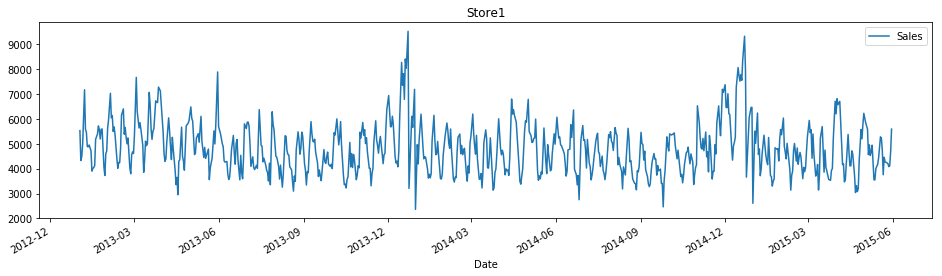

In [4]:
# sales of store1 full timne
strain = train[train.Sales>0]
strain.loc[strain['Store']==1 ,['Date','Sales']]     .plot(x='Date',y='Sales',title='Store1',figsize=(16,4))

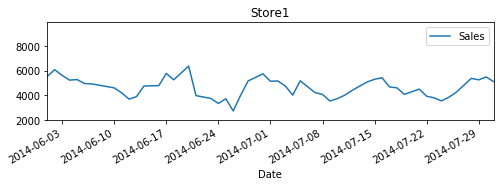

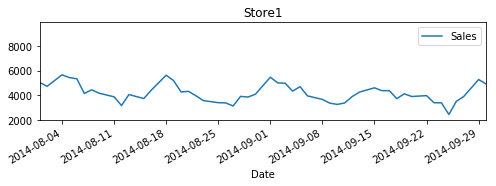

In [5]:
# sales of store1 ['2014-6-1','2014-7-31']v.s.['2014-8-1','2014-9-30']
strain = train[train.Sales>0]
strain.loc[strain['Store']==1 ,['Date','Sales']]     .plot(x='Date',y='Sales',title='Store1',figsize=(8,2),xlim=['2014-6-1','2014-7-31'])
strain.loc[strain['Store']==1 ,['Date','Sales']]     .plot(x='Date',y='Sales',title='Store1',figsize=(8,2),xlim=['2014-8-1','2014-9-30'])

In [6]:
# the store should be open in the test,so we fillna with 1
test.fillna(1, inplace=True)
#store['CompetitionDistance'].fillna(store['CompetitionDistance'].median(), inplace = True)
#store['CompetitionOpenScinceYear'].fillna(store['CompetitionDistance'].median(), inplace = True)
#store['CompetitionOPenScinceMonth'].fillna(store['CompetitionDistance'].median(), inplace = True)

In [7]:
# fillna in store with 0 has better result than median()
store.fillna(0, inplace=True)

In [8]:
display(train.isnull().sum(),test.isnull().sum(),store.isnull().sum())

Store            0
DayOfWeek        0
Date             0
Sales            0
Customers        0
Open             0
Promo            0
StateHoliday     0
SchoolHoliday    0
dtype: int64

ID               0
Store            0
DayOfWeek        0
Date             0
Open             0
Promo            0
StateHoliday     0
SchoolHoliday    0
dtype: int64

Store                        0
StoreType                    0
Assortment                   0
CompetitionDistance          0
CompetitionOpenSinceMonth    0
CompetitionOpenSinceYear     0
Promo2                       0
Promo2SinceWeek              0
Promo2SinceYear              0
PromoInterval                0
dtype: int64

In [9]:
train = pd.merge(train, store, on='Store')
test = pd.merge(test, store, on='Store')

In [10]:
# split the last 6 weeks data as hold-out set (idea from Gert https://www.kaggle.com/c/rossmann-store-sales/discussion/18024)
train = train.sort_values(['Date'],ascending = False)
ho_test = train[:6*7*1115]
ho_train = train[6*7*1115:]

In [11]:
# only use data of Sales>0 and Open is 1
ho_test = ho_test[ho_test["Open"] != 0]
ho_test = ho_test[ho_test["Sales"] > 0]
ho_train = ho_train[ho_train["Open"] != 0]
ho_train = ho_train[ho_train["Sales"] > 0]

In [12]:
# feature creation (code based on  https://www.kaggle.com/cast42/xgboost-in-python-with-rmspe-v2/code)
def features_create(data):
    
    
    mappings = {'0':0, 'a':1, 'b':2, 'c':3, 'd':4}
    data.StoreType.replace(mappings, inplace=True)
    data.Assortment.replace(mappings, inplace=True)
    data.StateHoliday.replace(mappings, inplace=True)
    
    
    data['Year'] = data.Date.dt.year
    data['Month'] = data.Date.dt.month
    data['Day'] = data.Date.dt.day
    data['DayOfWeek'] = data.Date.dt.dayofweek
    data['WeekOfYear'] = data.Date.dt.weekofyear
    
    
    
    data['CompetitionOpen'] = 12 * (data.Year - data.CompetitionOpenSinceYear) +         (data.Month - data.CompetitionOpenSinceMonth)
    data['PromoOpen'] = 12 * (data.Year - data.Promo2SinceYear) +         (data.WeekOfYear - data.Promo2SinceWeek) / 4.0
    data['CompetitionOpen'] = data.CompetitionOpen.apply(lambda x: x if x > 0 else 0)        
    data['PromoOpen'] = data.PromoOpen.apply(lambda x: x if x > 0 else 0)
    
    
  
    month2str = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun',              7:'Jul', 8:'Aug', 9:'Sept', 10:'Oct', 11:'Nov', 12:'Dec'}
    data['monthStr'] = data.Month.map(month2str)
    data.loc[data.PromoInterval == 0, 'PromoInterval'] = ''
    data['IsPromoMonth'] = 0
    for interval in data.PromoInterval.unique():
        if interval != '':
            for month in interval.split(','):
                data.loc[(data.monthStr == month) & (data.PromoInterval == interval), 'IsPromoMonth'] = 1

    return data

In [13]:
test.StateHoliday = test.StateHoliday.map(lambda x: str(x))

In [14]:
features_create(ho_train)
features_create(ho_test)
features_create(test)
print('Features creation finished')

Features creation finished


In [15]:
# drop the features of not help
ho_train.drop(['Date','Customers','Open','PromoInterval','monthStr',],axis=1,inplace =True)
ho_test.drop(['Date','Customers','Open','PromoInterval','monthStr',],axis=1,inplace =True)

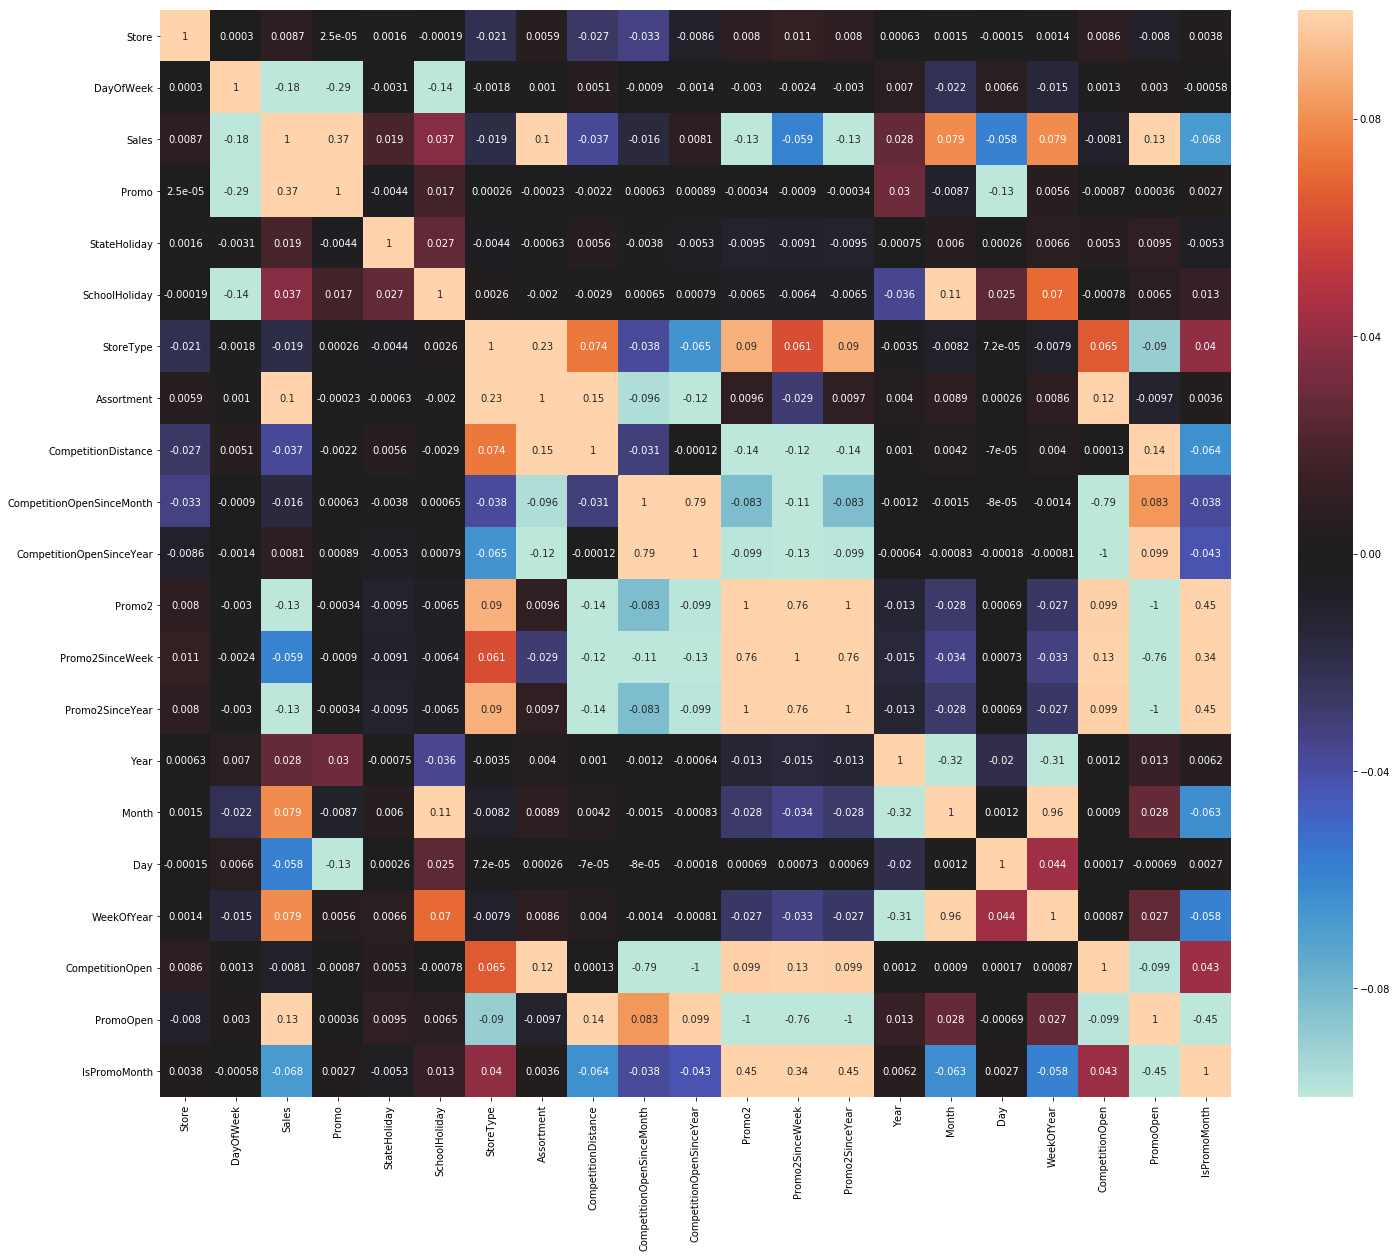

In [16]:
# the heat map of feature-feature and feature-label correlation 
plt.subplots(figsize=(24,20))
sns.heatmap(ho_train.corr(),annot=True, vmin=-0.1, vmax=0.1,center=0)

In [17]:
ho_xtrain = ho_train.drop(['Sales'],axis=1 )
ho_ytrain = np.log1p(ho_train.Sales)
ho_xtest = ho_test.drop(['Sales'],axis=1 )
ho_ytest = np.log1p(ho_test.Sales)

In [18]:
test.head()

,ID,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,...,Promo2SinceYear,PromoInterval,Year,Month,Day,WeekOfYear,CompetitionOpen,PromoOpen,monthStr,IsPromoMonth
0,1,1,5,2015-06-20,1,0,0,0,3,1,...,0.0,,2015,6,20,25,81.0,24186.25,Jun,0
1,1116,1,6,2015-06-21,0,0,0,0,3,1,...,0.0,,2015,6,21,25,81.0,24186.25,Jun,0
2,2231,1,0,2015-06-22,1,0,0,0,3,1,...,0.0,,2015,6,22,26,81.0,24186.50,Jun,0
3,3346,1,1,2015-06-23,1,0,0,0,3,1,...,0.0,,2015,6,23,26,81.0,24186.50,Jun,0
4,4461,1,2,2015-06-24,1,0,0,0,3,1,...,0.0,,2015,6,24,26,81.0,24186.50,Jun,0


In [19]:
xtest =test.drop(['ID','Date','Open','PromoInterval','monthStr'],axis = 1)

In [20]:
# define rmspe for xgb(code from https://www.kaggle.com/cast42/xgboost-in-python-with-rmspe-v2/code)
def rmspe(y, yhat):
    return np.sqrt(np.mean((yhat/y-1) ** 2))

def rmspe_xg(yhat, y):
    y = np.expm1(y.get_label())
    yhat = np.expm1(yhat)
    return "rmspe", rmspe(y,yhat)

In [24]:
params = {"objective": "reg:linear",
          "booster" : "gbtree",
          "eta": 0.01,
          "max_depth": 10,
          "subsample": 0.9,
          "colsample_bytree": 0.7,
          "silent": 1,
          "seed": 10,
          
          }
num_boost_round = 10000


dtrain = xgb.DMatrix(ho_xtrain, ho_ytrain)
dvalid = xgb.DMatrix(ho_xtest, ho_ytest)
watchlist = [(dtrain, 'train'), (dvalid, 'eval')]

#模型训练
print("Train a XGBoost model")
start = time()
gbm = xgb.train(params, dtrain, num_boost_round, evals=watchlist, 
  early_stopping_rounds=100, feval=rmspe_xg, verbose_eval=True)
end = time()
print('Training time is {:2f} s.'.format(end-start))

#采用保留数据集进行检测
print("validating")
ho_xtest.sort_index(inplace=True) 
ho_ytest.sort_index(inplace=True) 
yhat = gbm.predict(xgb.DMatrix(ho_xtest))
error = rmspe(np.expm1(ho_ytest), np.expm1(yhat))

print('RMSPE: {:.6f}'.format(error))

Train a XGBoost model
[0]	train-rmse:8.18137	eval-rmse:8.23212	train-rmspe:0.999863	eval-rmspe:0.999871
Multiple eval metrics have been passed: 'eval-rmspe' will be used for early stopping.

Will train until eval-rmspe hasn't improved in 100 rounds.
[1]	train-rmse:8.09972	eval-rmse:8.15057	train-rmspe:0.999837	eval-rmspe:0.999846
[2]	train-rmse:8.01891	eval-rmse:8.06977	train-rmspe:0.999808	eval-rmspe:0.99982
[3]	train-rmse:7.93889	eval-rmse:7.9898	train-rmspe:0.999778	eval-rmspe:0.999791
[4]	train-rmse:7.85967	eval-rmse:7.9108	train-rmspe:0.999746	eval-rmspe:0.999761
[5]	train-rmse:7.78125	eval-rmse:7.83253	train-rmspe:0.999711	eval-rmspe:0.999729
[6]	train-rmse:7.7036	eval-rmse:7.75497	train-rmspe:0.999674	eval-rmspe:0.999694
[7]	train-rmse:7.62672	eval-rmse:7.67825	train-rmspe:0.999635	eval-rmspe:0.999656
[8]	train-rmse:7.55062	eval-rmse:7.60233	train-rmspe:0.999592	eval-rmspe:0.999617
[9]	train-rmse:7.47527	eval-rmse:7.52715	train-rmspe:0.999547	eval-rmspe:0.999574
[10]	train-rmse:

[98]	train-rmse:3.06985	eval-rmse:3.12696	train-rmspe:0.95039	eval-rmspe:0.953394
[99]	train-rmse:3.03946	eval-rmse:3.09666	train-rmspe:0.948862	eval-rmspe:0.95196
[100]	train-rmse:3.00936	eval-rmse:3.06658	train-rmspe:0.947307	eval-rmspe:0.950496
[101]	train-rmse:2.97956	eval-rmse:3.03685	train-rmspe:0.94572	eval-rmspe:0.949006
[102]	train-rmse:2.95008	eval-rmse:3.00709	train-rmspe:0.944101	eval-rmspe:0.947469
[103]	train-rmse:2.92086	eval-rmse:2.97784	train-rmspe:0.942456	eval-rmspe:0.945919
[104]	train-rmse:2.89196	eval-rmse:2.94878	train-rmspe:0.940775	eval-rmspe:0.944327
[105]	train-rmse:2.86335	eval-rmse:2.92016	train-rmspe:0.939064	eval-rmspe:0.942716
[106]	train-rmse:2.83501	eval-rmse:2.89176	train-rmspe:0.937326	eval-rmspe:0.941074
[107]	train-rmse:2.80699	eval-rmse:2.86368	train-rmspe:0.93555	eval-rmspe:0.939396
[108]	train-rmse:2.77924	eval-rmse:2.83594	train-rmspe:0.933743	eval-rmspe:0.937693
[109]	train-rmse:2.75175	eval-rmse:2.80845	train-rmspe:0.93191	eval-rmspe:0.935964

[197]	train-rmse:1.1635	eval-rmse:1.21495	train-rmspe:0.672599	eval-rmspe:0.687987
[198]	train-rmse:1.15243	eval-rmse:1.20388	train-rmspe:0.669057	eval-rmspe:0.684563
[199]	train-rmse:1.14153	eval-rmse:1.193	train-rmspe:0.665509	eval-rmspe:0.68114
[200]	train-rmse:1.13077	eval-rmse:1.18207	train-rmspe:0.66196	eval-rmspe:0.677659
[201]	train-rmse:1.12011	eval-rmse:1.17116	train-rmspe:0.658411	eval-rmspe:0.674151
[202]	train-rmse:1.10948	eval-rmse:1.16051	train-rmspe:0.654878	eval-rmspe:0.670726
[203]	train-rmse:1.09905	eval-rmse:1.15005	train-rmspe:0.651336	eval-rmspe:0.667293
[204]	train-rmse:1.08872	eval-rmse:1.13966	train-rmspe:0.647797	eval-rmspe:0.66384
[205]	train-rmse:1.07832	eval-rmse:1.12919	train-rmspe:0.64428	eval-rmspe:0.660406
[206]	train-rmse:1.06813	eval-rmse:1.11894	train-rmspe:0.640758	eval-rmspe:0.656973
[207]	train-rmse:1.05807	eval-rmse:1.10878	train-rmspe:0.637233	eval-rmspe:0.653529
[208]	train-rmse:1.04816	eval-rmse:1.09887	train-rmspe:0.633704	eval-rmspe:0.650106

[294]	train-rmse:0.495407	eval-rmse:0.537153	train-rmspe:0.383511	eval-rmspe:0.394996
[295]	train-rmse:0.491662	eval-rmse:0.53327	train-rmspe:0.381491	eval-rmspe:0.392767
[296]	train-rmse:0.487973	eval-rmse:0.529432	train-rmspe:0.379514	eval-rmspe:0.39055
[297]	train-rmse:0.48433	eval-rmse:0.525667	train-rmspe:0.377546	eval-rmspe:0.388365
[298]	train-rmse:0.48074	eval-rmse:0.521964	train-rmspe:0.375579	eval-rmspe:0.386217
[299]	train-rmse:0.477183	eval-rmse:0.518329	train-rmspe:0.373648	eval-rmspe:0.384102
[300]	train-rmse:0.47365	eval-rmse:0.51471	train-rmspe:0.37174	eval-rmspe:0.381998
[301]	train-rmse:0.470092	eval-rmse:0.511042	train-rmspe:0.369832	eval-rmspe:0.379879
[302]	train-rmse:0.466525	eval-rmse:0.507406	train-rmspe:0.367912	eval-rmspe:0.377778
[303]	train-rmse:0.463089	eval-rmse:0.503783	train-rmspe:0.366064	eval-rmspe:0.375666
[304]	train-rmse:0.459725	eval-rmse:0.500319	train-rmspe:0.364244	eval-rmspe:0.373636
[305]	train-rmse:0.456421	eval-rmse:0.496784	train-rmspe:0.36

[390]	train-rmse:0.28372	eval-rmse:0.314295	train-rmspe:0.276626	eval-rmspe:0.262241
[391]	train-rmse:0.282638	eval-rmse:0.313028	train-rmspe:0.276221	eval-rmspe:0.261533
[392]	train-rmse:0.281582	eval-rmse:0.311791	train-rmspe:0.275839	eval-rmspe:0.260826
[393]	train-rmse:0.280587	eval-rmse:0.310677	train-rmspe:0.27549	eval-rmspe:0.260199
[394]	train-rmse:0.279527	eval-rmse:0.309536	train-rmspe:0.275124	eval-rmspe:0.259541
[395]	train-rmse:0.278364	eval-rmse:0.308266	train-rmspe:0.274603	eval-rmspe:0.258756
[396]	train-rmse:0.277219	eval-rmse:0.307095	train-rmspe:0.274114	eval-rmspe:0.258059
[397]	train-rmse:0.276244	eval-rmse:0.306002	train-rmspe:0.273763	eval-rmspe:0.257439
[398]	train-rmse:0.275312	eval-rmse:0.304986	train-rmspe:0.273412	eval-rmspe:0.256876
[399]	train-rmse:0.274411	eval-rmse:0.303959	train-rmspe:0.273084	eval-rmspe:0.256311
[400]	train-rmse:0.273469	eval-rmse:0.302902	train-rmspe:0.272776	eval-rmspe:0.255715
[401]	train-rmse:0.272593	eval-rmse:0.301938	train-rmspe

[486]	train-rmse:0.223767	eval-rmse:0.245192	train-rmspe:0.25749	eval-rmspe:0.2248
[487]	train-rmse:0.223412	eval-rmse:0.244787	train-rmspe:0.257381	eval-rmspe:0.224584
[488]	train-rmse:0.223103	eval-rmse:0.244402	train-rmspe:0.257245	eval-rmspe:0.224373
[489]	train-rmse:0.222885	eval-rmse:0.244111	train-rmspe:0.257259	eval-rmspe:0.224286
[490]	train-rmse:0.222648	eval-rmse:0.243829	train-rmspe:0.257276	eval-rmspe:0.224188
[491]	train-rmse:0.222006	eval-rmse:0.243151	train-rmspe:0.256902	eval-rmspe:0.223674
[492]	train-rmse:0.221739	eval-rmse:0.24279	train-rmspe:0.256896	eval-rmspe:0.223517
[493]	train-rmse:0.221359	eval-rmse:0.242318	train-rmspe:0.256764	eval-rmspe:0.223253
[494]	train-rmse:0.221026	eval-rmse:0.241896	train-rmspe:0.256678	eval-rmspe:0.223029
[495]	train-rmse:0.220502	eval-rmse:0.24136	train-rmspe:0.25641	eval-rmspe:0.222665
[496]	train-rmse:0.220294	eval-rmse:0.241075	train-rmspe:0.256432	eval-rmspe:0.222559
[497]	train-rmse:0.220007	eval-rmse:0.240719	train-rmspe:0.2

[582]	train-rmse:0.199449	eval-rmse:0.216789	train-rmspe:0.247498	eval-rmspe:0.208476
[583]	train-rmse:0.199379	eval-rmse:0.216711	train-rmspe:0.247514	eval-rmspe:0.208478
[584]	train-rmse:0.199149	eval-rmse:0.216477	train-rmspe:0.247389	eval-rmspe:0.208321
[585]	train-rmse:0.199037	eval-rmse:0.216342	train-rmspe:0.247366	eval-rmspe:0.208257
[586]	train-rmse:0.198822	eval-rmse:0.216069	train-rmspe:0.247256	eval-rmspe:0.208047
[587]	train-rmse:0.198701	eval-rmse:0.215938	train-rmspe:0.247118	eval-rmspe:0.207977
[588]	train-rmse:0.19861	eval-rmse:0.215807	train-rmspe:0.247107	eval-rmspe:0.207948
[589]	train-rmse:0.198551	eval-rmse:0.215716	train-rmspe:0.246823	eval-rmspe:0.20792
[590]	train-rmse:0.19846	eval-rmse:0.215588	train-rmspe:0.246839	eval-rmspe:0.207856
[591]	train-rmse:0.198332	eval-rmse:0.215433	train-rmspe:0.2468	eval-rmspe:0.207776
[592]	train-rmse:0.197999	eval-rmse:0.215081	train-rmspe:0.246568	eval-rmspe:0.207462
[593]	train-rmse:0.197916	eval-rmse:0.21493	train-rmspe:0.2

[678]	train-rmse:0.183558	eval-rmse:0.1998	train-rmspe:0.235646	eval-rmspe:0.195699
[679]	train-rmse:0.183427	eval-rmse:0.19967	train-rmspe:0.23555	eval-rmspe:0.195588
[680]	train-rmse:0.183231	eval-rmse:0.199477	train-rmspe:0.235372	eval-rmspe:0.195383
[681]	train-rmse:0.183176	eval-rmse:0.199422	train-rmspe:0.235313	eval-rmspe:0.195338
[682]	train-rmse:0.183005	eval-rmse:0.199254	train-rmspe:0.235193	eval-rmspe:0.195193
[683]	train-rmse:0.182846	eval-rmse:0.199092	train-rmspe:0.235082	eval-rmspe:0.195053
[684]	train-rmse:0.182629	eval-rmse:0.198874	train-rmspe:0.234927	eval-rmspe:0.194835
[685]	train-rmse:0.182443	eval-rmse:0.19869	train-rmspe:0.234793	eval-rmspe:0.194668
[686]	train-rmse:0.182283	eval-rmse:0.198526	train-rmspe:0.234679	eval-rmspe:0.194519
[687]	train-rmse:0.182125	eval-rmse:0.198367	train-rmspe:0.234567	eval-rmspe:0.194375
[688]	train-rmse:0.181978	eval-rmse:0.198214	train-rmspe:0.234467	eval-rmspe:0.194247
[689]	train-rmse:0.181686	eval-rmse:0.197952	train-rmspe:0.

[774]	train-rmse:0.169742	eval-rmse:0.186558	train-rmspe:0.219472	eval-rmspe:0.183643
[775]	train-rmse:0.169701	eval-rmse:0.186509	train-rmspe:0.219432	eval-rmspe:0.183619
[776]	train-rmse:0.169583	eval-rmse:0.186395	train-rmspe:0.219339	eval-rmspe:0.183504
[777]	train-rmse:0.169423	eval-rmse:0.186247	train-rmspe:0.219199	eval-rmspe:0.183354
[778]	train-rmse:0.169234	eval-rmse:0.186102	train-rmspe:0.219051	eval-rmspe:0.183218
[779]	train-rmse:0.168979	eval-rmse:0.185869	train-rmspe:0.218767	eval-rmspe:0.182984
[780]	train-rmse:0.168767	eval-rmse:0.185682	train-rmspe:0.218583	eval-rmspe:0.182813
[781]	train-rmse:0.168708	eval-rmse:0.185624	train-rmspe:0.218498	eval-rmspe:0.182769
[782]	train-rmse:0.168649	eval-rmse:0.185611	train-rmspe:0.218437	eval-rmspe:0.182799
[783]	train-rmse:0.168379	eval-rmse:0.18538	train-rmspe:0.218222	eval-rmspe:0.182573
[784]	train-rmse:0.168163	eval-rmse:0.185187	train-rmspe:0.218033	eval-rmspe:0.182395
[785]	train-rmse:0.168031	eval-rmse:0.185061	train-rmsp

[870]	train-rmse:0.157956	eval-rmse:0.175936	train-rmspe:0.205937	eval-rmspe:0.173368
[871]	train-rmse:0.157938	eval-rmse:0.175918	train-rmspe:0.205711	eval-rmspe:0.173352
[872]	train-rmse:0.157869	eval-rmse:0.175863	train-rmspe:0.205656	eval-rmspe:0.173298
[873]	train-rmse:0.157784	eval-rmse:0.175798	train-rmspe:0.205587	eval-rmspe:0.17323
[874]	train-rmse:0.157696	eval-rmse:0.175722	train-rmspe:0.205515	eval-rmspe:0.173154
[875]	train-rmse:0.157534	eval-rmse:0.175582	train-rmspe:0.205374	eval-rmspe:0.173014
[876]	train-rmse:0.157487	eval-rmse:0.175468	train-rmspe:0.205324	eval-rmspe:0.172915
[877]	train-rmse:0.157335	eval-rmse:0.175335	train-rmspe:0.205186	eval-rmspe:0.172777
[878]	train-rmse:0.157125	eval-rmse:0.175141	train-rmspe:0.204982	eval-rmspe:0.17257
[879]	train-rmse:0.157011	eval-rmse:0.175039	train-rmspe:0.204887	eval-rmspe:0.172465
[880]	train-rmse:0.156912	eval-rmse:0.174968	train-rmspe:0.204763	eval-rmspe:0.172388
[881]	train-rmse:0.156863	eval-rmse:0.174973	train-rmspe

[966]	train-rmse:0.148979	eval-rmse:0.168416	train-rmspe:0.193201	eval-rmspe:0.165736
[967]	train-rmse:0.148899	eval-rmse:0.168344	train-rmspe:0.193094	eval-rmspe:0.16566
[968]	train-rmse:0.148876	eval-rmse:0.168326	train-rmspe:0.192977	eval-rmspe:0.165642
[969]	train-rmse:0.148699	eval-rmse:0.168168	train-rmspe:0.192813	eval-rmspe:0.16548
[970]	train-rmse:0.148559	eval-rmse:0.168047	train-rmspe:0.192692	eval-rmspe:0.165357
[971]	train-rmse:0.148534	eval-rmse:0.168028	train-rmspe:0.192451	eval-rmspe:0.165337
[972]	train-rmse:0.148449	eval-rmse:0.167955	train-rmspe:0.192379	eval-rmspe:0.165266
[973]	train-rmse:0.148336	eval-rmse:0.167872	train-rmspe:0.192288	eval-rmspe:0.16518
[974]	train-rmse:0.148206	eval-rmse:0.16776	train-rmspe:0.19218	eval-rmspe:0.165071
[975]	train-rmse:0.148147	eval-rmse:0.167716	train-rmspe:0.192129	eval-rmspe:0.165024
[976]	train-rmse:0.148069	eval-rmse:0.167644	train-rmspe:0.19202	eval-rmspe:0.164947
[977]	train-rmse:0.148	eval-rmse:0.167586	train-rmspe:0.1919

[1062]	train-rmse:0.141265	eval-rmse:0.161364	train-rmspe:0.183744	eval-rmspe:0.158495
[1063]	train-rmse:0.141085	eval-rmse:0.161215	train-rmspe:0.18358	eval-rmspe:0.15834
[1064]	train-rmse:0.141068	eval-rmse:0.161202	train-rmspe:0.183565	eval-rmspe:0.158324
[1065]	train-rmse:0.141044	eval-rmse:0.161184	train-rmspe:0.183543	eval-rmspe:0.158305
[1066]	train-rmse:0.141022	eval-rmse:0.161172	train-rmspe:0.183521	eval-rmspe:0.158311
[1067]	train-rmse:0.141002	eval-rmse:0.161158	train-rmspe:0.183491	eval-rmspe:0.1583
[1068]	train-rmse:0.140936	eval-rmse:0.161108	train-rmspe:0.183433	eval-rmspe:0.158248
[1069]	train-rmse:0.140835	eval-rmse:0.161015	train-rmspe:0.183341	eval-rmspe:0.15815
[1070]	train-rmse:0.14072	eval-rmse:0.160916	train-rmspe:0.183247	eval-rmspe:0.15805
[1071]	train-rmse:0.140685	eval-rmse:0.160889	train-rmspe:0.183215	eval-rmspe:0.158021
[1072]	train-rmse:0.140604	eval-rmse:0.16083	train-rmspe:0.183147	eval-rmspe:0.157954
[1073]	train-rmse:0.140507	eval-rmse:0.160759	train

[1157]	train-rmse:0.134818	eval-rmse:0.156071	train-rmspe:0.176113	eval-rmspe:0.153031
[1158]	train-rmse:0.134793	eval-rmse:0.156052	train-rmspe:0.17609	eval-rmspe:0.153007
[1159]	train-rmse:0.134751	eval-rmse:0.156008	train-rmspe:0.176053	eval-rmspe:0.152961
[1160]	train-rmse:0.134713	eval-rmse:0.156001	train-rmspe:0.175997	eval-rmspe:0.152948
[1161]	train-rmse:0.134613	eval-rmse:0.155925	train-rmspe:0.175908	eval-rmspe:0.152867
[1162]	train-rmse:0.134596	eval-rmse:0.155894	train-rmspe:0.175884	eval-rmspe:0.152838
[1163]	train-rmse:0.134529	eval-rmse:0.155836	train-rmspe:0.175824	eval-rmspe:0.152778
[1164]	train-rmse:0.134497	eval-rmse:0.155805	train-rmspe:0.175769	eval-rmspe:0.152742
[1165]	train-rmse:0.134468	eval-rmse:0.155797	train-rmspe:0.175715	eval-rmspe:0.152733
[1166]	train-rmse:0.134402	eval-rmse:0.15573	train-rmspe:0.175658	eval-rmspe:0.152667
[1167]	train-rmse:0.134386	eval-rmse:0.155718	train-rmspe:0.175483	eval-rmspe:0.152654
[1168]	train-rmse:0.134252	eval-rmse:0.155612

[1252]	train-rmse:0.129117	eval-rmse:0.15139	train-rmspe:0.169328	eval-rmspe:0.14815
[1253]	train-rmse:0.129035	eval-rmse:0.151325	train-rmspe:0.169226	eval-rmspe:0.148068
[1254]	train-rmse:0.128945	eval-rmse:0.15125	train-rmspe:0.169151	eval-rmspe:0.147991
[1255]	train-rmse:0.12891	eval-rmse:0.151254	train-rmspe:0.169118	eval-rmspe:0.14799
[1256]	train-rmse:0.128871	eval-rmse:0.151222	train-rmspe:0.169065	eval-rmspe:0.147965
[1257]	train-rmse:0.128823	eval-rmse:0.15118	train-rmspe:0.169021	eval-rmspe:0.147923
[1258]	train-rmse:0.128805	eval-rmse:0.151168	train-rmspe:0.168886	eval-rmspe:0.147909
[1259]	train-rmse:0.128744	eval-rmse:0.151116	train-rmspe:0.168815	eval-rmspe:0.14785
[1260]	train-rmse:0.12873	eval-rmse:0.151105	train-rmspe:0.168781	eval-rmspe:0.14784
[1261]	train-rmse:0.128669	eval-rmse:0.151059	train-rmspe:0.16873	eval-rmspe:0.147791
[1262]	train-rmse:0.128642	eval-rmse:0.151048	train-rmspe:0.168035	eval-rmspe:0.147769
[1263]	train-rmse:0.128589	eval-rmse:0.151	train-rmsp

[1347]	train-rmse:0.125187	eval-rmse:0.148095	train-rmspe:0.163579	eval-rmspe:0.144675
[1348]	train-rmse:0.125068	eval-rmse:0.148006	train-rmspe:0.163448	eval-rmspe:0.144568
[1349]	train-rmse:0.125017	eval-rmse:0.147968	train-rmspe:0.16339	eval-rmspe:0.144529
[1350]	train-rmse:0.12496	eval-rmse:0.147921	train-rmspe:0.163337	eval-rmspe:0.144481
[1351]	train-rmse:0.124925	eval-rmse:0.147884	train-rmspe:0.163266	eval-rmspe:0.144441
[1352]	train-rmse:0.124876	eval-rmse:0.147847	train-rmspe:0.163221	eval-rmspe:0.144404
[1353]	train-rmse:0.124833	eval-rmse:0.147812	train-rmspe:0.163188	eval-rmspe:0.14437
[1354]	train-rmse:0.124821	eval-rmse:0.147805	train-rmspe:0.16309	eval-rmspe:0.144362
[1355]	train-rmse:0.124779	eval-rmse:0.147774	train-rmspe:0.163048	eval-rmspe:0.144332
[1356]	train-rmse:0.124754	eval-rmse:0.14775	train-rmspe:0.163022	eval-rmspe:0.144305
[1357]	train-rmse:0.124685	eval-rmse:0.147694	train-rmspe:0.162957	eval-rmspe:0.144246
[1358]	train-rmse:0.124659	eval-rmse:0.147639	tr

[1442]	train-rmse:0.121273	eval-rmse:0.145131	train-rmspe:0.158782	eval-rmspe:0.141561
[1443]	train-rmse:0.12126	eval-rmse:0.145126	train-rmspe:0.158712	eval-rmspe:0.141554
[1444]	train-rmse:0.121217	eval-rmse:0.145096	train-rmspe:0.158675	eval-rmspe:0.141523
[1445]	train-rmse:0.121165	eval-rmse:0.145049	train-rmspe:0.158628	eval-rmspe:0.141472
[1446]	train-rmse:0.121134	eval-rmse:0.145022	train-rmspe:0.158589	eval-rmspe:0.141445
[1447]	train-rmse:0.121094	eval-rmse:0.144983	train-rmspe:0.158556	eval-rmspe:0.141405
[1448]	train-rmse:0.121074	eval-rmse:0.14497	train-rmspe:0.158538	eval-rmspe:0.141393
[1449]	train-rmse:0.121063	eval-rmse:0.144962	train-rmspe:0.158529	eval-rmspe:0.141383
[1450]	train-rmse:0.121031	eval-rmse:0.144934	train-rmspe:0.1585	eval-rmspe:0.141355
[1451]	train-rmse:0.121018	eval-rmse:0.144927	train-rmspe:0.158474	eval-rmspe:0.141347
[1452]	train-rmse:0.120958	eval-rmse:0.144907	train-rmspe:0.15835	eval-rmspe:0.141318
[1453]	train-rmse:0.120907	eval-rmse:0.14487	tra

[1537]	train-rmse:0.117686	eval-rmse:0.142595	train-rmspe:0.154747	eval-rmspe:0.138783
[1538]	train-rmse:0.117671	eval-rmse:0.142556	train-rmspe:0.154728	eval-rmspe:0.138745
[1539]	train-rmse:0.11764	eval-rmse:0.14254	train-rmspe:0.15469	eval-rmspe:0.138729
[1540]	train-rmse:0.11762	eval-rmse:0.142531	train-rmspe:0.154671	eval-rmspe:0.138719
[1541]	train-rmse:0.117576	eval-rmse:0.142495	train-rmspe:0.154631	eval-rmspe:0.138682
[1542]	train-rmse:0.117506	eval-rmse:0.14244	train-rmspe:0.154575	eval-rmspe:0.138626
[1543]	train-rmse:0.117461	eval-rmse:0.142405	train-rmspe:0.154541	eval-rmspe:0.138588
[1544]	train-rmse:0.11739	eval-rmse:0.142358	train-rmspe:0.15448	eval-rmspe:0.138538
[1545]	train-rmse:0.117348	eval-rmse:0.142359	train-rmspe:0.154381	eval-rmspe:0.138527
[1546]	train-rmse:0.117303	eval-rmse:0.142324	train-rmspe:0.154342	eval-rmspe:0.138493
[1547]	train-rmse:0.117246	eval-rmse:0.142263	train-rmspe:0.154288	eval-rmspe:0.138431
[1548]	train-rmse:0.117238	eval-rmse:0.142258	trai

[1632]	train-rmse:0.114213	eval-rmse:0.14021	train-rmspe:0.151251	eval-rmspe:0.136199
[1633]	train-rmse:0.114162	eval-rmse:0.14018	train-rmspe:0.151204	eval-rmspe:0.136166
[1634]	train-rmse:0.114099	eval-rmse:0.140136	train-rmspe:0.151149	eval-rmspe:0.136117
[1635]	train-rmse:0.114088	eval-rmse:0.140132	train-rmspe:0.151136	eval-rmspe:0.136116
[1636]	train-rmse:0.114041	eval-rmse:0.140078	train-rmspe:0.151093	eval-rmspe:0.136054
[1637]	train-rmse:0.114016	eval-rmse:0.140069	train-rmspe:0.151069	eval-rmspe:0.136042
[1638]	train-rmse:0.113998	eval-rmse:0.140056	train-rmspe:0.151042	eval-rmspe:0.136028
[1639]	train-rmse:0.113969	eval-rmse:0.140035	train-rmspe:0.151008	eval-rmspe:0.136006
[1640]	train-rmse:0.113929	eval-rmse:0.140005	train-rmspe:0.150974	eval-rmspe:0.135977
[1641]	train-rmse:0.113907	eval-rmse:0.139988	train-rmspe:0.15096	eval-rmspe:0.135958
[1642]	train-rmse:0.11385	eval-rmse:0.139946	train-rmspe:0.150904	eval-rmspe:0.135914
[1643]	train-rmse:0.11383	eval-rmse:0.139937	tr

[1727]	train-rmse:0.111318	eval-rmse:0.138333	train-rmspe:0.148196	eval-rmspe:0.13412
[1728]	train-rmse:0.111276	eval-rmse:0.138301	train-rmspe:0.148161	eval-rmspe:0.134086
[1729]	train-rmse:0.111262	eval-rmse:0.13829	train-rmspe:0.148148	eval-rmspe:0.134075
[1730]	train-rmse:0.111253	eval-rmse:0.138303	train-rmspe:0.148137	eval-rmspe:0.134094
[1731]	train-rmse:0.111224	eval-rmse:0.138281	train-rmspe:0.148116	eval-rmspe:0.134069
[1732]	train-rmse:0.111211	eval-rmse:0.138271	train-rmspe:0.148103	eval-rmspe:0.134058
[1733]	train-rmse:0.111196	eval-rmse:0.138266	train-rmspe:0.148091	eval-rmspe:0.134052
[1734]	train-rmse:0.111163	eval-rmse:0.138251	train-rmspe:0.148062	eval-rmspe:0.134034
[1735]	train-rmse:0.111136	eval-rmse:0.13823	train-rmspe:0.148036	eval-rmspe:0.134011
[1736]	train-rmse:0.111111	eval-rmse:0.13821	train-rmspe:0.148016	eval-rmspe:0.133989
[1737]	train-rmse:0.111094	eval-rmse:0.138199	train-rmspe:0.148001	eval-rmspe:0.133976
[1738]	train-rmse:0.111025	eval-rmse:0.138148	t

[1822]	train-rmse:0.108737	eval-rmse:0.136592	train-rmspe:0.145658	eval-rmspe:0.132215
[1823]	train-rmse:0.108716	eval-rmse:0.13658	train-rmspe:0.145638	eval-rmspe:0.132201
[1824]	train-rmse:0.108685	eval-rmse:0.13656	train-rmspe:0.145605	eval-rmspe:0.132179
[1825]	train-rmse:0.108657	eval-rmse:0.136551	train-rmspe:0.145582	eval-rmspe:0.132169
[1826]	train-rmse:0.108636	eval-rmse:0.136541	train-rmspe:0.145558	eval-rmspe:0.132156
[1827]	train-rmse:0.108621	eval-rmse:0.136531	train-rmspe:0.145539	eval-rmspe:0.132145
[1828]	train-rmse:0.108597	eval-rmse:0.136512	train-rmspe:0.145519	eval-rmspe:0.132123
[1829]	train-rmse:0.108584	eval-rmse:0.136484	train-rmspe:0.145509	eval-rmspe:0.132092
[1830]	train-rmse:0.108529	eval-rmse:0.136451	train-rmspe:0.145447	eval-rmspe:0.132061
[1831]	train-rmse:0.108507	eval-rmse:0.136426	train-rmspe:0.145428	eval-rmspe:0.132039
[1832]	train-rmse:0.108485	eval-rmse:0.136395	train-rmspe:0.145409	eval-rmspe:0.132009
[1833]	train-rmse:0.108458	eval-rmse:0.136359

[1917]	train-rmse:0.106421	eval-rmse:0.135107	train-rmspe:0.142481	eval-rmspe:0.130586
[1918]	train-rmse:0.106397	eval-rmse:0.135089	train-rmspe:0.142461	eval-rmspe:0.130564
[1919]	train-rmse:0.10638	eval-rmse:0.135072	train-rmspe:0.142447	eval-rmspe:0.130547
[1920]	train-rmse:0.106363	eval-rmse:0.135063	train-rmspe:0.142432	eval-rmspe:0.130535
[1921]	train-rmse:0.106346	eval-rmse:0.135052	train-rmspe:0.142418	eval-rmspe:0.130524
[1922]	train-rmse:0.106323	eval-rmse:0.135035	train-rmspe:0.1424	eval-rmspe:0.130508
[1923]	train-rmse:0.10631	eval-rmse:0.13505	train-rmspe:0.142381	eval-rmspe:0.13052
[1924]	train-rmse:0.106285	eval-rmse:0.135029	train-rmspe:0.142361	eval-rmspe:0.130495
[1925]	train-rmse:0.106262	eval-rmse:0.135013	train-rmspe:0.142342	eval-rmspe:0.130476
[1926]	train-rmse:0.106244	eval-rmse:0.134986	train-rmspe:0.142326	eval-rmspe:0.130449
[1927]	train-rmse:0.106212	eval-rmse:0.134966	train-rmspe:0.142301	eval-rmspe:0.130427
[1928]	train-rmse:0.106198	eval-rmse:0.134956	tra

[2012]	train-rmse:0.1044	eval-rmse:0.133951	train-rmspe:0.140581	eval-rmspe:0.129288
[2013]	train-rmse:0.104379	eval-rmse:0.133939	train-rmspe:0.139702	eval-rmspe:0.129272
[2014]	train-rmse:0.104356	eval-rmse:0.133922	train-rmspe:0.139703	eval-rmspe:0.129255
[2015]	train-rmse:0.104337	eval-rmse:0.133911	train-rmspe:0.139682	eval-rmspe:0.129243
[2016]	train-rmse:0.104295	eval-rmse:0.133877	train-rmspe:0.139646	eval-rmspe:0.129202
[2017]	train-rmse:0.104275	eval-rmse:0.13386	train-rmspe:0.13963	eval-rmspe:0.129185
[2018]	train-rmse:0.104252	eval-rmse:0.133849	train-rmspe:0.139608	eval-rmspe:0.129172
[2019]	train-rmse:0.104223	eval-rmse:0.133828	train-rmspe:0.139585	eval-rmspe:0.129149
[2020]	train-rmse:0.1042	eval-rmse:0.133807	train-rmspe:0.13955	eval-rmspe:0.129126
[2021]	train-rmse:0.104183	eval-rmse:0.133835	train-rmspe:0.139536	eval-rmspe:0.129155
[2022]	train-rmse:0.104162	eval-rmse:0.133825	train-rmspe:0.139516	eval-rmspe:0.129143
[2023]	train-rmse:0.104152	eval-rmse:0.13382	train

[2107]	train-rmse:0.102643	eval-rmse:0.132926	train-rmspe:0.138108	eval-rmspe:0.128143
[2108]	train-rmse:0.102626	eval-rmse:0.132913	train-rmspe:0.138085	eval-rmspe:0.128129
[2109]	train-rmse:0.102608	eval-rmse:0.132901	train-rmspe:0.138066	eval-rmspe:0.128117
[2110]	train-rmse:0.102591	eval-rmse:0.132893	train-rmspe:0.138052	eval-rmspe:0.128108
[2111]	train-rmse:0.102572	eval-rmse:0.132882	train-rmspe:0.13803	eval-rmspe:0.128098
[2112]	train-rmse:0.102542	eval-rmse:0.13286	train-rmspe:0.137988	eval-rmspe:0.128074
[2113]	train-rmse:0.102526	eval-rmse:0.132855	train-rmspe:0.137974	eval-rmspe:0.12807
[2114]	train-rmse:0.102506	eval-rmse:0.132835	train-rmspe:0.137958	eval-rmspe:0.128048
[2115]	train-rmse:0.102488	eval-rmse:0.132821	train-rmspe:0.137943	eval-rmspe:0.128034
[2116]	train-rmse:0.102479	eval-rmse:0.132816	train-rmspe:0.13793	eval-rmspe:0.128028
[2117]	train-rmse:0.102457	eval-rmse:0.132803	train-rmspe:0.137908	eval-rmspe:0.128016
[2118]	train-rmse:0.102438	eval-rmse:0.132795	t

[2202]	train-rmse:0.100977	eval-rmse:0.131923	train-rmspe:0.136298	eval-rmspe:0.127072
[2203]	train-rmse:0.100969	eval-rmse:0.131921	train-rmspe:0.136306	eval-rmspe:0.127069
[2204]	train-rmse:0.100948	eval-rmse:0.131911	train-rmspe:0.136288	eval-rmspe:0.127059
[2205]	train-rmse:0.100924	eval-rmse:0.131901	train-rmspe:0.136269	eval-rmspe:0.127049
[2206]	train-rmse:0.100908	eval-rmse:0.13189	train-rmspe:0.136256	eval-rmspe:0.127038
[2207]	train-rmse:0.1009	eval-rmse:0.131888	train-rmspe:0.136249	eval-rmspe:0.127036
[2208]	train-rmse:0.100886	eval-rmse:0.131886	train-rmspe:0.136238	eval-rmspe:0.127034
[2209]	train-rmse:0.100858	eval-rmse:0.131867	train-rmspe:0.136218	eval-rmspe:0.127013
[2210]	train-rmse:0.100837	eval-rmse:0.131851	train-rmspe:0.136219	eval-rmspe:0.127001
[2211]	train-rmse:0.100821	eval-rmse:0.131839	train-rmspe:0.136206	eval-rmspe:0.12699
[2212]	train-rmse:0.100811	eval-rmse:0.131832	train-rmspe:0.136197	eval-rmspe:0.126984
[2213]	train-rmse:0.100797	eval-rmse:0.131824	t

[2297]	train-rmse:0.099471	eval-rmse:0.131231	train-rmspe:0.134401	eval-rmspe:0.126257
[2298]	train-rmse:0.099441	eval-rmse:0.131211	train-rmspe:0.134374	eval-rmspe:0.126236
[2299]	train-rmse:0.099425	eval-rmse:0.131202	train-rmspe:0.134354	eval-rmspe:0.126224
[2300]	train-rmse:0.099391	eval-rmse:0.131182	train-rmspe:0.134321	eval-rmspe:0.126203
[2301]	train-rmse:0.099373	eval-rmse:0.13117	train-rmspe:0.134308	eval-rmspe:0.126191
[2302]	train-rmse:0.099365	eval-rmse:0.131167	train-rmspe:0.134304	eval-rmspe:0.126188
[2303]	train-rmse:0.099351	eval-rmse:0.131159	train-rmspe:0.134292	eval-rmspe:0.12618
[2304]	train-rmse:0.099339	eval-rmse:0.131157	train-rmspe:0.134279	eval-rmspe:0.126177
[2305]	train-rmse:0.099325	eval-rmse:0.131146	train-rmspe:0.134267	eval-rmspe:0.126163
[2306]	train-rmse:0.099311	eval-rmse:0.131138	train-rmspe:0.134258	eval-rmspe:0.126154
[2307]	train-rmse:0.099287	eval-rmse:0.131123	train-rmspe:0.13423	eval-rmspe:0.126139
[2308]	train-rmse:0.099274	eval-rmse:0.13112	t

[2392]	train-rmse:0.098017	eval-rmse:0.130479	train-rmspe:0.132862	eval-rmspe:0.125437
[2393]	train-rmse:0.098001	eval-rmse:0.130487	train-rmspe:0.13284	eval-rmspe:0.125437
[2394]	train-rmse:0.097988	eval-rmse:0.130478	train-rmspe:0.132817	eval-rmspe:0.125428
[2395]	train-rmse:0.097968	eval-rmse:0.130464	train-rmspe:0.132799	eval-rmspe:0.125413
[2396]	train-rmse:0.097954	eval-rmse:0.130479	train-rmspe:0.132782	eval-rmspe:0.125424
[2397]	train-rmse:0.097935	eval-rmse:0.130468	train-rmspe:0.132767	eval-rmspe:0.125412
[2398]	train-rmse:0.097915	eval-rmse:0.130466	train-rmspe:0.132726	eval-rmspe:0.125413
[2399]	train-rmse:0.097903	eval-rmse:0.130457	train-rmspe:0.132712	eval-rmspe:0.125401
[2400]	train-rmse:0.097874	eval-rmse:0.130441	train-rmspe:0.132688	eval-rmspe:0.125381
[2401]	train-rmse:0.097857	eval-rmse:0.130421	train-rmspe:0.132669	eval-rmspe:0.125363
[2402]	train-rmse:0.09784	eval-rmse:0.130432	train-rmspe:0.132655	eval-rmspe:0.125369
[2403]	train-rmse:0.097832	eval-rmse:0.130432

[2487]	train-rmse:0.096657	eval-rmse:0.12993	train-rmspe:0.12986	eval-rmspe:0.124755
[2488]	train-rmse:0.096651	eval-rmse:0.129928	train-rmspe:0.129852	eval-rmspe:0.124753
[2489]	train-rmse:0.096641	eval-rmse:0.129926	train-rmspe:0.129844	eval-rmspe:0.124751
[2490]	train-rmse:0.09662	eval-rmse:0.129915	train-rmspe:0.129824	eval-rmspe:0.124739
[2491]	train-rmse:0.096591	eval-rmse:0.129894	train-rmspe:0.129793	eval-rmspe:0.124716
[2492]	train-rmse:0.096578	eval-rmse:0.129887	train-rmspe:0.129782	eval-rmspe:0.124709
[2493]	train-rmse:0.096569	eval-rmse:0.129882	train-rmspe:0.128991	eval-rmspe:0.124704
[2494]	train-rmse:0.096559	eval-rmse:0.129873	train-rmspe:0.128983	eval-rmspe:0.124693
[2495]	train-rmse:0.096538	eval-rmse:0.12986	train-rmspe:0.128953	eval-rmspe:0.124679
[2496]	train-rmse:0.096511	eval-rmse:0.129843	train-rmspe:0.128915	eval-rmspe:0.124661
[2497]	train-rmse:0.096498	eval-rmse:0.129836	train-rmspe:0.128897	eval-rmspe:0.124654
[2498]	train-rmse:0.096484	eval-rmse:0.129827	t

[2582]	train-rmse:0.09551	eval-rmse:0.129423	train-rmspe:0.126824	eval-rmspe:0.124141
[2583]	train-rmse:0.095503	eval-rmse:0.129427	train-rmspe:0.12681	eval-rmspe:0.124142
[2584]	train-rmse:0.095496	eval-rmse:0.129423	train-rmspe:0.126804	eval-rmspe:0.124138
[2585]	train-rmse:0.095488	eval-rmse:0.129422	train-rmspe:0.126798	eval-rmspe:0.124138
[2586]	train-rmse:0.095478	eval-rmse:0.129415	train-rmspe:0.12679	eval-rmspe:0.124129
[2587]	train-rmse:0.095468	eval-rmse:0.129422	train-rmspe:0.12678	eval-rmspe:0.124134
[2588]	train-rmse:0.095447	eval-rmse:0.129405	train-rmspe:0.126755	eval-rmspe:0.124118
[2589]	train-rmse:0.09544	eval-rmse:0.129404	train-rmspe:0.126749	eval-rmspe:0.124118
[2590]	train-rmse:0.09543	eval-rmse:0.129398	train-rmspe:0.126731	eval-rmspe:0.124112
[2591]	train-rmse:0.095427	eval-rmse:0.129397	train-rmspe:0.126727	eval-rmspe:0.12411
[2592]	train-rmse:0.095414	eval-rmse:0.129403	train-rmspe:0.126708	eval-rmspe:0.124112
[2593]	train-rmse:0.095399	eval-rmse:0.129402	trai

[2677]	train-rmse:0.094339	eval-rmse:0.128906	train-rmspe:0.124126	eval-rmspe:0.123518
[2678]	train-rmse:0.094328	eval-rmse:0.128901	train-rmspe:0.124111	eval-rmspe:0.123512
[2679]	train-rmse:0.094315	eval-rmse:0.128893	train-rmspe:0.124099	eval-rmspe:0.123504
[2680]	train-rmse:0.094309	eval-rmse:0.12889	train-rmspe:0.124088	eval-rmspe:0.123495
[2681]	train-rmse:0.094282	eval-rmse:0.12887	train-rmspe:0.124064	eval-rmspe:0.123476
[2682]	train-rmse:0.094271	eval-rmse:0.128863	train-rmspe:0.124054	eval-rmspe:0.123469
[2683]	train-rmse:0.094262	eval-rmse:0.128864	train-rmspe:0.124046	eval-rmspe:0.123468
[2684]	train-rmse:0.094241	eval-rmse:0.12885	train-rmspe:0.124026	eval-rmspe:0.123454
[2685]	train-rmse:0.094204	eval-rmse:0.128838	train-rmspe:0.123992	eval-rmspe:0.123438
[2686]	train-rmse:0.094194	eval-rmse:0.128832	train-rmspe:0.123983	eval-rmspe:0.123433
[2687]	train-rmse:0.094178	eval-rmse:0.128851	train-rmspe:0.123962	eval-rmspe:0.123446
[2688]	train-rmse:0.094168	eval-rmse:0.128852	

[2772]	train-rmse:0.093311	eval-rmse:0.128531	train-rmspe:0.122365	eval-rmspe:0.12307
[2773]	train-rmse:0.093297	eval-rmse:0.128522	train-rmspe:0.122338	eval-rmspe:0.123064
[2774]	train-rmse:0.093279	eval-rmse:0.128511	train-rmspe:0.122316	eval-rmspe:0.123052
[2775]	train-rmse:0.093263	eval-rmse:0.128505	train-rmspe:0.1223	eval-rmspe:0.123045
[2776]	train-rmse:0.093253	eval-rmse:0.128503	train-rmspe:0.12229	eval-rmspe:0.123044
[2777]	train-rmse:0.093238	eval-rmse:0.128499	train-rmspe:0.122275	eval-rmspe:0.12304
[2778]	train-rmse:0.093227	eval-rmse:0.128496	train-rmspe:0.122265	eval-rmspe:0.123036
[2779]	train-rmse:0.093209	eval-rmse:0.128483	train-rmspe:0.122241	eval-rmspe:0.123022
[2780]	train-rmse:0.093202	eval-rmse:0.128494	train-rmspe:0.122228	eval-rmspe:0.123029
[2781]	train-rmse:0.0932	eval-rmse:0.128492	train-rmspe:0.122227	eval-rmspe:0.123028
[2782]	train-rmse:0.093192	eval-rmse:0.128496	train-rmspe:0.122219	eval-rmspe:0.123031
[2783]	train-rmse:0.093184	eval-rmse:0.128495	trai

[2867]	train-rmse:0.092257	eval-rmse:0.128202	train-rmspe:0.121126	eval-rmspe:0.122637
[2868]	train-rmse:0.092246	eval-rmse:0.128217	train-rmspe:0.121117	eval-rmspe:0.122652
[2869]	train-rmse:0.092236	eval-rmse:0.128215	train-rmspe:0.121109	eval-rmspe:0.122649
[2870]	train-rmse:0.092222	eval-rmse:0.128207	train-rmspe:0.121095	eval-rmspe:0.122641
[2871]	train-rmse:0.092212	eval-rmse:0.128207	train-rmspe:0.121088	eval-rmspe:0.122639
[2872]	train-rmse:0.092207	eval-rmse:0.128202	train-rmspe:0.12109	eval-rmspe:0.122635
[2873]	train-rmse:0.092202	eval-rmse:0.128195	train-rmspe:0.121085	eval-rmspe:0.122629
[2874]	train-rmse:0.092187	eval-rmse:0.128185	train-rmspe:0.121063	eval-rmspe:0.122617
[2875]	train-rmse:0.092176	eval-rmse:0.128179	train-rmspe:0.121052	eval-rmspe:0.122611
[2876]	train-rmse:0.092166	eval-rmse:0.128185	train-rmspe:0.120875	eval-rmspe:0.122613
[2877]	train-rmse:0.092148	eval-rmse:0.128176	train-rmspe:0.120859	eval-rmspe:0.122603
[2878]	train-rmse:0.092143	eval-rmse:0.12818

[2962]	train-rmse:0.091289	eval-rmse:0.127904	train-rmspe:0.119732	eval-rmspe:0.122259
[2963]	train-rmse:0.091281	eval-rmse:0.1279	train-rmspe:0.119725	eval-rmspe:0.122256
[2964]	train-rmse:0.091279	eval-rmse:0.1279	train-rmspe:0.119732	eval-rmspe:0.122254
[2965]	train-rmse:0.09127	eval-rmse:0.127894	train-rmspe:0.119721	eval-rmspe:0.122249
[2966]	train-rmse:0.091261	eval-rmse:0.127888	train-rmspe:0.119709	eval-rmspe:0.122244
[2967]	train-rmse:0.091256	eval-rmse:0.127889	train-rmspe:0.119702	eval-rmspe:0.122248
[2968]	train-rmse:0.09125	eval-rmse:0.12789	train-rmspe:0.119692	eval-rmspe:0.122249
[2969]	train-rmse:0.09123	eval-rmse:0.127883	train-rmspe:0.119676	eval-rmspe:0.12224
[2970]	train-rmse:0.09122	eval-rmse:0.127882	train-rmspe:0.119661	eval-rmspe:0.122238
[2971]	train-rmse:0.091214	eval-rmse:0.127878	train-rmspe:0.119654	eval-rmspe:0.122231
[2972]	train-rmse:0.091211	eval-rmse:0.127879	train-rmspe:0.119654	eval-rmspe:0.122231
[2973]	train-rmse:0.091194	eval-rmse:0.12787	train-rm

[3057]	train-rmse:0.090408	eval-rmse:0.127626	train-rmspe:0.117601	eval-rmspe:0.121912
[3058]	train-rmse:0.090392	eval-rmse:0.127615	train-rmspe:0.117588	eval-rmspe:0.121899
[3059]	train-rmse:0.090387	eval-rmse:0.127613	train-rmspe:0.117583	eval-rmspe:0.121897
[3060]	train-rmse:0.090375	eval-rmse:0.127608	train-rmspe:0.117571	eval-rmspe:0.121893
[3061]	train-rmse:0.090367	eval-rmse:0.127601	train-rmspe:0.117562	eval-rmspe:0.121887
[3062]	train-rmse:0.09036	eval-rmse:0.127597	train-rmspe:0.117557	eval-rmspe:0.121883
[3063]	train-rmse:0.090352	eval-rmse:0.127599	train-rmspe:0.117374	eval-rmspe:0.121883
[3064]	train-rmse:0.090344	eval-rmse:0.127597	train-rmspe:0.117362	eval-rmspe:0.121881
[3065]	train-rmse:0.090334	eval-rmse:0.127592	train-rmspe:0.117354	eval-rmspe:0.121875
[3066]	train-rmse:0.090326	eval-rmse:0.127589	train-rmspe:0.11734	eval-rmspe:0.121872
[3067]	train-rmse:0.090314	eval-rmse:0.127581	train-rmspe:0.117329	eval-rmspe:0.121864
[3068]	train-rmse:0.090305	eval-rmse:0.12758	

[3152]	train-rmse:0.089566	eval-rmse:0.12739	train-rmspe:0.115923	eval-rmspe:0.12162
[3153]	train-rmse:0.089561	eval-rmse:0.127388	train-rmspe:0.115917	eval-rmspe:0.121617
[3154]	train-rmse:0.089554	eval-rmse:0.127384	train-rmspe:0.115912	eval-rmspe:0.121614
[3155]	train-rmse:0.089539	eval-rmse:0.127377	train-rmspe:0.115894	eval-rmspe:0.121605
[3156]	train-rmse:0.08953	eval-rmse:0.127372	train-rmspe:0.115884	eval-rmspe:0.1216
[3157]	train-rmse:0.089517	eval-rmse:0.127368	train-rmspe:0.115872	eval-rmspe:0.121594
[3158]	train-rmse:0.089489	eval-rmse:0.127349	train-rmspe:0.115845	eval-rmspe:0.121573
[3159]	train-rmse:0.089478	eval-rmse:0.127343	train-rmspe:0.115823	eval-rmspe:0.121567
[3160]	train-rmse:0.089472	eval-rmse:0.127349	train-rmspe:0.115814	eval-rmspe:0.121574
[3161]	train-rmse:0.089461	eval-rmse:0.127351	train-rmspe:0.115804	eval-rmspe:0.121574
[3162]	train-rmse:0.089451	eval-rmse:0.127348	train-rmspe:0.115794	eval-rmspe:0.121571
[3163]	train-rmse:0.089444	eval-rmse:0.127345	tr

[3247]	train-rmse:0.088767	eval-rmse:0.127112	train-rmspe:0.113354	eval-rmspe:0.121298
[3248]	train-rmse:0.088761	eval-rmse:0.12711	train-rmspe:0.113344	eval-rmspe:0.121297
[3249]	train-rmse:0.08875	eval-rmse:0.127109	train-rmspe:0.113326	eval-rmspe:0.121296
[3250]	train-rmse:0.088745	eval-rmse:0.127108	train-rmspe:0.113321	eval-rmspe:0.121296
[3251]	train-rmse:0.088737	eval-rmse:0.127105	train-rmspe:0.113314	eval-rmspe:0.121292
[3252]	train-rmse:0.088732	eval-rmse:0.127104	train-rmspe:0.113309	eval-rmspe:0.121292
[3253]	train-rmse:0.088721	eval-rmse:0.127098	train-rmspe:0.113292	eval-rmspe:0.121286
[3254]	train-rmse:0.088711	eval-rmse:0.127094	train-rmspe:0.113282	eval-rmspe:0.121281
[3255]	train-rmse:0.088702	eval-rmse:0.127092	train-rmspe:0.113275	eval-rmspe:0.121278
[3256]	train-rmse:0.088695	eval-rmse:0.127087	train-rmspe:0.113268	eval-rmspe:0.121274
[3257]	train-rmse:0.088686	eval-rmse:0.127096	train-rmspe:0.113252	eval-rmspe:0.121282
[3258]	train-rmse:0.088671	eval-rmse:0.127085

[3342]	train-rmse:0.087989	eval-rmse:0.126876	train-rmspe:0.111284	eval-rmspe:0.121011
[3343]	train-rmse:0.087983	eval-rmse:0.126874	train-rmspe:0.111277	eval-rmspe:0.121008
[3344]	train-rmse:0.087974	eval-rmse:0.12687	train-rmspe:0.111269	eval-rmspe:0.121004
[3345]	train-rmse:0.087958	eval-rmse:0.12686	train-rmspe:0.111254	eval-rmspe:0.120993
[3346]	train-rmse:0.08795	eval-rmse:0.126857	train-rmspe:0.111246	eval-rmspe:0.120989
[3347]	train-rmse:0.087944	eval-rmse:0.126857	train-rmspe:0.111239	eval-rmspe:0.120989
[3348]	train-rmse:0.087936	eval-rmse:0.126855	train-rmspe:0.111229	eval-rmspe:0.120989
[3349]	train-rmse:0.087927	eval-rmse:0.126851	train-rmspe:0.111221	eval-rmspe:0.120985
[3350]	train-rmse:0.087922	eval-rmse:0.12685	train-rmspe:0.111215	eval-rmspe:0.120983
[3351]	train-rmse:0.087917	eval-rmse:0.126846	train-rmspe:0.111209	eval-rmspe:0.12098
[3352]	train-rmse:0.087901	eval-rmse:0.126833	train-rmspe:0.111196	eval-rmspe:0.120962
[3353]	train-rmse:0.087892	eval-rmse:0.12683	tra

[3437]	train-rmse:0.087245	eval-rmse:0.126718	train-rmspe:0.109782	eval-rmspe:0.12078
[3438]	train-rmse:0.087241	eval-rmse:0.126717	train-rmspe:0.109778	eval-rmspe:0.120777
[3439]	train-rmse:0.087235	eval-rmse:0.126717	train-rmspe:0.109773	eval-rmspe:0.120777
[3440]	train-rmse:0.087224	eval-rmse:0.126713	train-rmspe:0.109759	eval-rmspe:0.120773
[3441]	train-rmse:0.087218	eval-rmse:0.126711	train-rmspe:0.109754	eval-rmspe:0.120769
[3442]	train-rmse:0.087209	eval-rmse:0.12671	train-rmspe:0.109746	eval-rmspe:0.120768
[3443]	train-rmse:0.087199	eval-rmse:0.126706	train-rmspe:0.109737	eval-rmspe:0.120763
[3444]	train-rmse:0.087187	eval-rmse:0.126697	train-rmspe:0.109255	eval-rmspe:0.12075
[3445]	train-rmse:0.08718	eval-rmse:0.126698	train-rmspe:0.109246	eval-rmspe:0.12075
[3446]	train-rmse:0.087173	eval-rmse:0.126696	train-rmspe:0.109238	eval-rmspe:0.120749
[3447]	train-rmse:0.087171	eval-rmse:0.12671	train-rmspe:0.109235	eval-rmspe:0.12076
[3448]	train-rmse:0.087164	eval-rmse:0.126706	trai

[3532]	train-rmse:0.086561	eval-rmse:0.126565	train-rmspe:0.10833	eval-rmspe:0.120587
[3533]	train-rmse:0.08655	eval-rmse:0.126576	train-rmspe:0.108304	eval-rmspe:0.120602
[3534]	train-rmse:0.086545	eval-rmse:0.126575	train-rmspe:0.108297	eval-rmspe:0.1206
[3535]	train-rmse:0.086538	eval-rmse:0.126571	train-rmspe:0.108295	eval-rmspe:0.120596
[3536]	train-rmse:0.086532	eval-rmse:0.12657	train-rmspe:0.108303	eval-rmspe:0.120595
[3537]	train-rmse:0.086525	eval-rmse:0.126567	train-rmspe:0.108295	eval-rmspe:0.120592
[3538]	train-rmse:0.086516	eval-rmse:0.126562	train-rmspe:0.108287	eval-rmspe:0.120585
[3539]	train-rmse:0.086508	eval-rmse:0.126558	train-rmspe:0.108279	eval-rmspe:0.120582
[3540]	train-rmse:0.086498	eval-rmse:0.126555	train-rmspe:0.108265	eval-rmspe:0.120579
[3541]	train-rmse:0.086494	eval-rmse:0.126554	train-rmspe:0.108261	eval-rmspe:0.120577
[3542]	train-rmse:0.086486	eval-rmse:0.126551	train-rmspe:0.108253	eval-rmspe:0.120574
[3543]	train-rmse:0.086481	eval-rmse:0.126556	tr

[3627]	train-rmse:0.085873	eval-rmse:0.126438	train-rmspe:0.107478	eval-rmspe:0.120419
[3628]	train-rmse:0.085866	eval-rmse:0.126438	train-rmspe:0.107469	eval-rmspe:0.120416
[3629]	train-rmse:0.085858	eval-rmse:0.126434	train-rmspe:0.107454	eval-rmspe:0.120412
[3630]	train-rmse:0.085851	eval-rmse:0.126433	train-rmspe:0.107443	eval-rmspe:0.120411
[3631]	train-rmse:0.085849	eval-rmse:0.126437	train-rmspe:0.10744	eval-rmspe:0.120413
[3632]	train-rmse:0.085839	eval-rmse:0.126432	train-rmspe:0.107431	eval-rmspe:0.120408
[3633]	train-rmse:0.085834	eval-rmse:0.12643	train-rmspe:0.107427	eval-rmspe:0.120406
[3634]	train-rmse:0.085828	eval-rmse:0.126428	train-rmspe:0.107411	eval-rmspe:0.120404
[3635]	train-rmse:0.085826	eval-rmse:0.126428	train-rmspe:0.107409	eval-rmspe:0.120403
[3636]	train-rmse:0.085811	eval-rmse:0.126418	train-rmspe:0.107408	eval-rmspe:0.120393
[3637]	train-rmse:0.085806	eval-rmse:0.126417	train-rmspe:0.107403	eval-rmspe:0.120392
[3638]	train-rmse:0.085804	eval-rmse:0.126415

[3722]	train-rmse:0.085193	eval-rmse:0.126277	train-rmspe:0.105433	eval-rmspe:0.120202
[3723]	train-rmse:0.085189	eval-rmse:0.126275	train-rmspe:0.105429	eval-rmspe:0.1202
[3724]	train-rmse:0.085177	eval-rmse:0.126268	train-rmspe:0.105418	eval-rmspe:0.120193
[3725]	train-rmse:0.085173	eval-rmse:0.12627	train-rmspe:0.105413	eval-rmspe:0.120195
[3726]	train-rmse:0.08517	eval-rmse:0.126269	train-rmspe:0.10541	eval-rmspe:0.120194
[3727]	train-rmse:0.085165	eval-rmse:0.126268	train-rmspe:0.105409	eval-rmspe:0.120193
[3728]	train-rmse:0.085155	eval-rmse:0.126262	train-rmspe:0.105396	eval-rmspe:0.120186
[3729]	train-rmse:0.08515	eval-rmse:0.126261	train-rmspe:0.105392	eval-rmspe:0.120186
[3730]	train-rmse:0.085143	eval-rmse:0.126263	train-rmspe:0.105385	eval-rmspe:0.120186
[3731]	train-rmse:0.085137	eval-rmse:0.12626	train-rmspe:0.105378	eval-rmspe:0.120184
[3732]	train-rmse:0.085129	eval-rmse:0.126252	train-rmspe:0.105368	eval-rmspe:0.120177
[3733]	train-rmse:0.085121	eval-rmse:0.12625	train

[3817]	train-rmse:0.08454	eval-rmse:0.126112	train-rmspe:0.104373	eval-rmspe:0.119986
[3818]	train-rmse:0.084532	eval-rmse:0.126111	train-rmspe:0.104361	eval-rmspe:0.119985
[3819]	train-rmse:0.084528	eval-rmse:0.12611	train-rmspe:0.104357	eval-rmspe:0.119983
[3820]	train-rmse:0.084523	eval-rmse:0.126107	train-rmspe:0.104353	eval-rmspe:0.119979
[3821]	train-rmse:0.084518	eval-rmse:0.126114	train-rmspe:0.104346	eval-rmspe:0.11999
[3822]	train-rmse:0.084513	eval-rmse:0.126111	train-rmspe:0.104341	eval-rmspe:0.119988
[3823]	train-rmse:0.084511	eval-rmse:0.12611	train-rmspe:0.104334	eval-rmspe:0.119987
[3824]	train-rmse:0.084504	eval-rmse:0.126109	train-rmspe:0.104327	eval-rmspe:0.119986
[3825]	train-rmse:0.084498	eval-rmse:0.126107	train-rmspe:0.104322	eval-rmspe:0.119984
[3826]	train-rmse:0.084485	eval-rmse:0.126101	train-rmspe:0.10431	eval-rmspe:0.119977
[3827]	train-rmse:0.08448	eval-rmse:0.126099	train-rmspe:0.104305	eval-rmspe:0.119975
[3828]	train-rmse:0.08447	eval-rmse:0.126096	trai

[3912]	train-rmse:0.083928	eval-rmse:0.126018	train-rmspe:0.102361	eval-rmspe:0.119857
[3913]	train-rmse:0.083922	eval-rmse:0.126018	train-rmspe:0.102355	eval-rmspe:0.119858
[3914]	train-rmse:0.083917	eval-rmse:0.126015	train-rmspe:0.102349	eval-rmspe:0.119855
[3915]	train-rmse:0.083912	eval-rmse:0.126014	train-rmspe:0.102345	eval-rmspe:0.119853
[3916]	train-rmse:0.083906	eval-rmse:0.126012	train-rmspe:0.102337	eval-rmspe:0.11985
[3917]	train-rmse:0.083893	eval-rmse:0.126004	train-rmspe:0.102326	eval-rmspe:0.119841
[3918]	train-rmse:0.083885	eval-rmse:0.126004	train-rmspe:0.102314	eval-rmspe:0.119841
[3919]	train-rmse:0.08388	eval-rmse:0.126002	train-rmspe:0.102304	eval-rmspe:0.119839
[3920]	train-rmse:0.083874	eval-rmse:0.125999	train-rmspe:0.102299	eval-rmspe:0.119836
[3921]	train-rmse:0.08387	eval-rmse:0.125998	train-rmspe:0.102294	eval-rmspe:0.119834
[3922]	train-rmse:0.083866	eval-rmse:0.125997	train-rmspe:0.102289	eval-rmspe:0.119833
[3923]	train-rmse:0.083861	eval-rmse:0.125998	

[4007]	train-rmse:0.083382	eval-rmse:0.125949	train-rmspe:0.10041	eval-rmspe:0.119757
[4008]	train-rmse:0.083378	eval-rmse:0.125949	train-rmspe:0.100405	eval-rmspe:0.119756
[4009]	train-rmse:0.083372	eval-rmse:0.125948	train-rmspe:0.1004	eval-rmspe:0.119755
[4010]	train-rmse:0.083368	eval-rmse:0.125947	train-rmspe:0.100393	eval-rmspe:0.119754
[4011]	train-rmse:0.083362	eval-rmse:0.125947	train-rmspe:0.100384	eval-rmspe:0.119755
[4012]	train-rmse:0.08336	eval-rmse:0.125948	train-rmspe:0.100395	eval-rmspe:0.119754
[4013]	train-rmse:0.083354	eval-rmse:0.125945	train-rmspe:0.100389	eval-rmspe:0.119752
[4014]	train-rmse:0.083346	eval-rmse:0.125944	train-rmspe:0.100374	eval-rmspe:0.119751
[4015]	train-rmse:0.083342	eval-rmse:0.125945	train-rmspe:0.10037	eval-rmspe:0.119752
[4016]	train-rmse:0.083335	eval-rmse:0.125947	train-rmspe:0.100358	eval-rmspe:0.119755
[4017]	train-rmse:0.083328	eval-rmse:0.125945	train-rmspe:0.100352	eval-rmspe:0.119753
[4018]	train-rmse:0.083325	eval-rmse:0.125947	tr

[4102]	train-rmse:0.082826	eval-rmse:0.125843	train-rmspe:0.099216	eval-rmspe:0.119628
[4103]	train-rmse:0.082821	eval-rmse:0.125841	train-rmspe:0.099211	eval-rmspe:0.119626
[4104]	train-rmse:0.082815	eval-rmse:0.125837	train-rmspe:0.099204	eval-rmspe:0.119623
[4105]	train-rmse:0.082812	eval-rmse:0.125837	train-rmspe:0.099203	eval-rmspe:0.119622
[4106]	train-rmse:0.082805	eval-rmse:0.125852	train-rmspe:0.099192	eval-rmspe:0.119631
[4107]	train-rmse:0.0828	eval-rmse:0.125851	train-rmspe:0.099186	eval-rmspe:0.11963
[4108]	train-rmse:0.082795	eval-rmse:0.125849	train-rmspe:0.098912	eval-rmspe:0.119628
[4109]	train-rmse:0.082789	eval-rmse:0.125851	train-rmspe:0.098901	eval-rmspe:0.119632
[4110]	train-rmse:0.082781	eval-rmse:0.125846	train-rmspe:0.098892	eval-rmspe:0.119626
[4111]	train-rmse:0.082776	eval-rmse:0.125844	train-rmspe:0.098886	eval-rmspe:0.119624
[4112]	train-rmse:0.082772	eval-rmse:0.125841	train-rmspe:0.098882	eval-rmspe:0.119621
[4113]	train-rmse:0.082768	eval-rmse:0.12584	t

[4197]	train-rmse:0.082333	eval-rmse:0.125761	train-rmspe:0.09817	eval-rmspe:0.119506
[4198]	train-rmse:0.082329	eval-rmse:0.125761	train-rmspe:0.098166	eval-rmspe:0.119505
[4199]	train-rmse:0.082325	eval-rmse:0.125759	train-rmspe:0.098162	eval-rmspe:0.119501
[4200]	train-rmse:0.082319	eval-rmse:0.125758	train-rmspe:0.098155	eval-rmspe:0.1195
[4201]	train-rmse:0.082312	eval-rmse:0.125754	train-rmspe:0.098148	eval-rmspe:0.119496
[4202]	train-rmse:0.082301	eval-rmse:0.125748	train-rmspe:0.098135	eval-rmspe:0.11949
[4203]	train-rmse:0.08229	eval-rmse:0.125743	train-rmspe:0.098126	eval-rmspe:0.119484
[4204]	train-rmse:0.082284	eval-rmse:0.125741	train-rmspe:0.098117	eval-rmspe:0.119481
[4205]	train-rmse:0.082276	eval-rmse:0.125737	train-rmspe:0.098108	eval-rmspe:0.119478
[4206]	train-rmse:0.082271	eval-rmse:0.125736	train-rmspe:0.098102	eval-rmspe:0.119477
[4207]	train-rmse:0.082269	eval-rmse:0.125745	train-rmspe:0.0981	eval-rmspe:0.119482
[4208]	train-rmse:0.082263	eval-rmse:0.125753	trai

[4292]	train-rmse:0.081803	eval-rmse:0.125677	train-rmspe:0.097003	eval-rmspe:0.11938
[4293]	train-rmse:0.081798	eval-rmse:0.125674	train-rmspe:0.096997	eval-rmspe:0.119377
[4294]	train-rmse:0.081791	eval-rmse:0.125673	train-rmspe:0.096989	eval-rmspe:0.119375
[4295]	train-rmse:0.081787	eval-rmse:0.125671	train-rmspe:0.096749	eval-rmspe:0.119372
[4296]	train-rmse:0.081782	eval-rmse:0.125673	train-rmspe:0.096744	eval-rmspe:0.119373
[4297]	train-rmse:0.081776	eval-rmse:0.125672	train-rmspe:0.096738	eval-rmspe:0.119372
[4298]	train-rmse:0.081769	eval-rmse:0.125669	train-rmspe:0.096724	eval-rmspe:0.119369
[4299]	train-rmse:0.081765	eval-rmse:0.125668	train-rmspe:0.09672	eval-rmspe:0.119368
[4300]	train-rmse:0.08176	eval-rmse:0.125667	train-rmspe:0.096715	eval-rmspe:0.119366
[4301]	train-rmse:0.081755	eval-rmse:0.125667	train-rmspe:0.096709	eval-rmspe:0.119365
[4302]	train-rmse:0.08175	eval-rmse:0.125666	train-rmspe:0.096703	eval-rmspe:0.119365
[4303]	train-rmse:0.081745	eval-rmse:0.125666	t

[4387]	train-rmse:0.0813	eval-rmse:0.125651	train-rmspe:0.095676	eval-rmspe:0.119311
[4388]	train-rmse:0.081292	eval-rmse:0.125647	train-rmspe:0.095669	eval-rmspe:0.119307
[4389]	train-rmse:0.081288	eval-rmse:0.125644	train-rmspe:0.095654	eval-rmspe:0.119305
[4390]	train-rmse:0.081285	eval-rmse:0.125643	train-rmspe:0.095651	eval-rmspe:0.119304
[4391]	train-rmse:0.081276	eval-rmse:0.125642	train-rmspe:0.095641	eval-rmspe:0.119302
[4392]	train-rmse:0.08127	eval-rmse:0.12564	train-rmspe:0.09553	eval-rmspe:0.119299
[4393]	train-rmse:0.081266	eval-rmse:0.125639	train-rmspe:0.095492	eval-rmspe:0.119298
[4394]	train-rmse:0.081263	eval-rmse:0.125637	train-rmspe:0.09549	eval-rmspe:0.119295
[4395]	train-rmse:0.081258	eval-rmse:0.125636	train-rmspe:0.095484	eval-rmspe:0.119293
[4396]	train-rmse:0.081248	eval-rmse:0.125633	train-rmspe:0.095474	eval-rmspe:0.11929
[4397]	train-rmse:0.081244	eval-rmse:0.125632	train-rmspe:0.09547	eval-rmspe:0.119289
[4398]	train-rmse:0.08124	eval-rmse:0.125628	train-

[4482]	train-rmse:0.080775	eval-rmse:0.125539	train-rmspe:0.09431	eval-rmspe:0.119176
[4483]	train-rmse:0.080766	eval-rmse:0.125537	train-rmspe:0.094295	eval-rmspe:0.119174
[4484]	train-rmse:0.080762	eval-rmse:0.125539	train-rmspe:0.094289	eval-rmspe:0.119174
[4485]	train-rmse:0.080755	eval-rmse:0.125536	train-rmspe:0.094186	eval-rmspe:0.119172
[4486]	train-rmse:0.080752	eval-rmse:0.125536	train-rmspe:0.094183	eval-rmspe:0.119172
[4487]	train-rmse:0.080748	eval-rmse:0.125536	train-rmspe:0.094178	eval-rmspe:0.119171
[4488]	train-rmse:0.080745	eval-rmse:0.125536	train-rmspe:0.094175	eval-rmspe:0.119171
[4489]	train-rmse:0.080739	eval-rmse:0.125535	train-rmspe:0.094169	eval-rmspe:0.119168
[4490]	train-rmse:0.080734	eval-rmse:0.125532	train-rmspe:0.094163	eval-rmspe:0.119166
[4491]	train-rmse:0.080729	eval-rmse:0.125537	train-rmspe:0.094155	eval-rmspe:0.119169
[4492]	train-rmse:0.080725	eval-rmse:0.125539	train-rmspe:0.09415	eval-rmspe:0.119172
[4493]	train-rmse:0.08072	eval-rmse:0.125538	

[4577]	train-rmse:0.080296	eval-rmse:0.125466	train-rmspe:0.09322	eval-rmspe:0.119079
[4578]	train-rmse:0.080289	eval-rmse:0.125462	train-rmspe:0.093212	eval-rmspe:0.119075
[4579]	train-rmse:0.080283	eval-rmse:0.125458	train-rmspe:0.093206	eval-rmspe:0.119071
[4580]	train-rmse:0.080279	eval-rmse:0.125458	train-rmspe:0.093202	eval-rmspe:0.119072
[4581]	train-rmse:0.080272	eval-rmse:0.125455	train-rmspe:0.093192	eval-rmspe:0.119069
[4582]	train-rmse:0.08027	eval-rmse:0.125456	train-rmspe:0.093191	eval-rmspe:0.119069
[4583]	train-rmse:0.080265	eval-rmse:0.125456	train-rmspe:0.093185	eval-rmspe:0.119068
[4584]	train-rmse:0.08026	eval-rmse:0.125452	train-rmspe:0.093179	eval-rmspe:0.119065
[4585]	train-rmse:0.080255	eval-rmse:0.125451	train-rmspe:0.093175	eval-rmspe:0.119063
[4586]	train-rmse:0.080251	eval-rmse:0.125451	train-rmspe:0.093169	eval-rmspe:0.119063
[4587]	train-rmse:0.080246	eval-rmse:0.125449	train-rmspe:0.093162	eval-rmspe:0.119061
[4588]	train-rmse:0.080243	eval-rmse:0.125448	

[4672]	train-rmse:0.079837	eval-rmse:0.12539	train-rmspe:0.09226	eval-rmspe:0.118972
[4673]	train-rmse:0.079835	eval-rmse:0.125389	train-rmspe:0.092258	eval-rmspe:0.118971
[4674]	train-rmse:0.079832	eval-rmse:0.125388	train-rmspe:0.092255	eval-rmspe:0.118971
[4675]	train-rmse:0.079821	eval-rmse:0.125381	train-rmspe:0.092244	eval-rmspe:0.118964
[4676]	train-rmse:0.079815	eval-rmse:0.125381	train-rmspe:0.092236	eval-rmspe:0.118964
[4677]	train-rmse:0.079812	eval-rmse:0.125381	train-rmspe:0.092233	eval-rmspe:0.118964
[4678]	train-rmse:0.079807	eval-rmse:0.125383	train-rmspe:0.09222	eval-rmspe:0.118965
[4679]	train-rmse:0.079803	eval-rmse:0.125383	train-rmspe:0.092212	eval-rmspe:0.118965
[4680]	train-rmse:0.079798	eval-rmse:0.125381	train-rmspe:0.092206	eval-rmspe:0.118963
[4681]	train-rmse:0.079793	eval-rmse:0.125379	train-rmspe:0.09219	eval-rmspe:0.118962
[4682]	train-rmse:0.079789	eval-rmse:0.125378	train-rmspe:0.092181	eval-rmspe:0.11896
[4683]	train-rmse:0.079784	eval-rmse:0.125376	tr

[4767]	train-rmse:0.07937	eval-rmse:0.125369	train-rmspe:0.091052	eval-rmspe:0.11891
[4768]	train-rmse:0.079366	eval-rmse:0.125368	train-rmspe:0.091047	eval-rmspe:0.118909
[4769]	train-rmse:0.079362	eval-rmse:0.125368	train-rmspe:0.091043	eval-rmspe:0.11891
[4770]	train-rmse:0.079357	eval-rmse:0.125367	train-rmspe:0.091038	eval-rmspe:0.118909
[4771]	train-rmse:0.079353	eval-rmse:0.125367	train-rmspe:0.091028	eval-rmspe:0.118908
[4772]	train-rmse:0.079344	eval-rmse:0.125364	train-rmspe:0.09101	eval-rmspe:0.118904
[4773]	train-rmse:0.07934	eval-rmse:0.125363	train-rmspe:0.091005	eval-rmspe:0.118903
[4774]	train-rmse:0.079332	eval-rmse:0.12536	train-rmspe:0.090998	eval-rmspe:0.1189
[4775]	train-rmse:0.07933	eval-rmse:0.125359	train-rmspe:0.090995	eval-rmspe:0.118899
[4776]	train-rmse:0.079325	eval-rmse:0.125357	train-rmspe:0.090989	eval-rmspe:0.118898
[4777]	train-rmse:0.07932	eval-rmse:0.125356	train-rmspe:0.090978	eval-rmspe:0.118897
[4778]	train-rmse:0.079316	eval-rmse:0.125355	train-r

[4862]	train-rmse:0.078944	eval-rmse:0.125344	train-rmspe:0.090366	eval-rmspe:0.11885
[4863]	train-rmse:0.07894	eval-rmse:0.125343	train-rmspe:0.090363	eval-rmspe:0.118849
[4864]	train-rmse:0.078936	eval-rmse:0.125343	train-rmspe:0.090351	eval-rmspe:0.118849
[4865]	train-rmse:0.078928	eval-rmse:0.125338	train-rmspe:0.090344	eval-rmspe:0.118844
[4866]	train-rmse:0.078922	eval-rmse:0.125339	train-rmspe:0.090337	eval-rmspe:0.118844
[4867]	train-rmse:0.078918	eval-rmse:0.125343	train-rmspe:0.090334	eval-rmspe:0.118846
[4868]	train-rmse:0.078915	eval-rmse:0.125342	train-rmspe:0.090328	eval-rmspe:0.118846
[4869]	train-rmse:0.07891	eval-rmse:0.125341	train-rmspe:0.090323	eval-rmspe:0.118844
[4870]	train-rmse:0.078907	eval-rmse:0.12534	train-rmspe:0.090319	eval-rmspe:0.118844
[4871]	train-rmse:0.078901	eval-rmse:0.125339	train-rmspe:0.090311	eval-rmspe:0.118842
[4872]	train-rmse:0.078898	eval-rmse:0.125338	train-rmspe:0.090309	eval-rmspe:0.118841
[4873]	train-rmse:0.078893	eval-rmse:0.125336	t

[4957]	train-rmse:0.078525	eval-rmse:0.125293	train-rmspe:0.089554	eval-rmspe:0.118777
[4958]	train-rmse:0.078521	eval-rmse:0.125293	train-rmspe:0.089549	eval-rmspe:0.118776
[4959]	train-rmse:0.078518	eval-rmse:0.125294	train-rmspe:0.089541	eval-rmspe:0.118777
[4960]	train-rmse:0.078513	eval-rmse:0.125293	train-rmspe:0.089536	eval-rmspe:0.118775
[4961]	train-rmse:0.078508	eval-rmse:0.125292	train-rmspe:0.089531	eval-rmspe:0.118776
[4962]	train-rmse:0.078506	eval-rmse:0.125293	train-rmspe:0.089529	eval-rmspe:0.118777
[4963]	train-rmse:0.078501	eval-rmse:0.125292	train-rmspe:0.089522	eval-rmspe:0.118775
[4964]	train-rmse:0.078495	eval-rmse:0.12529	train-rmspe:0.089515	eval-rmspe:0.118774
[4965]	train-rmse:0.078491	eval-rmse:0.125296	train-rmspe:0.089507	eval-rmspe:0.118782
[4966]	train-rmse:0.078486	eval-rmse:0.125295	train-rmspe:0.089502	eval-rmspe:0.118781
[4967]	train-rmse:0.078482	eval-rmse:0.125295	train-rmspe:0.089497	eval-rmspe:0.118781
[4968]	train-rmse:0.078479	eval-rmse:0.12529

[5052]	train-rmse:0.078098	eval-rmse:0.125235	train-rmspe:0.088761	eval-rmspe:0.118708
[5053]	train-rmse:0.078095	eval-rmse:0.125235	train-rmspe:0.088757	eval-rmspe:0.118708
[5054]	train-rmse:0.078091	eval-rmse:0.125233	train-rmspe:0.088752	eval-rmspe:0.118705
[5055]	train-rmse:0.078086	eval-rmse:0.125234	train-rmspe:0.088746	eval-rmspe:0.118705
[5056]	train-rmse:0.078081	eval-rmse:0.125232	train-rmspe:0.088741	eval-rmspe:0.118703
[5057]	train-rmse:0.078077	eval-rmse:0.125231	train-rmspe:0.088736	eval-rmspe:0.118702
[5058]	train-rmse:0.078074	eval-rmse:0.12523	train-rmspe:0.088732	eval-rmspe:0.1187
[5059]	train-rmse:0.078071	eval-rmse:0.12523	train-rmspe:0.088729	eval-rmspe:0.1187
[5060]	train-rmse:0.078068	eval-rmse:0.125229	train-rmspe:0.088727	eval-rmspe:0.118699
[5061]	train-rmse:0.078063	eval-rmse:0.125227	train-rmspe:0.088721	eval-rmspe:0.118698
[5062]	train-rmse:0.078061	eval-rmse:0.125227	train-rmspe:0.08872	eval-rmspe:0.118698
[5063]	train-rmse:0.078055	eval-rmse:0.125227	trai

[5147]	train-rmse:0.077708	eval-rmse:0.125197	train-rmspe:0.087854	eval-rmspe:0.118646
[5148]	train-rmse:0.077703	eval-rmse:0.125208	train-rmspe:0.087845	eval-rmspe:0.118654
[5149]	train-rmse:0.077699	eval-rmse:0.125207	train-rmspe:0.08784	eval-rmspe:0.118652
[5150]	train-rmse:0.077696	eval-rmse:0.125208	train-rmspe:0.087836	eval-rmspe:0.118654
[5151]	train-rmse:0.07769	eval-rmse:0.125207	train-rmspe:0.087829	eval-rmspe:0.118653
[5152]	train-rmse:0.077687	eval-rmse:0.125209	train-rmspe:0.087827	eval-rmspe:0.118654
[5153]	train-rmse:0.077684	eval-rmse:0.125209	train-rmspe:0.087823	eval-rmspe:0.118654
[5154]	train-rmse:0.077679	eval-rmse:0.125208	train-rmspe:0.087814	eval-rmspe:0.118653
[5155]	train-rmse:0.077674	eval-rmse:0.125205	train-rmspe:0.087809	eval-rmspe:0.11865
[5156]	train-rmse:0.07767	eval-rmse:0.125199	train-rmspe:0.087789	eval-rmspe:0.118648
[5157]	train-rmse:0.077667	eval-rmse:0.125199	train-rmspe:0.087785	eval-rmspe:0.118647
[5158]	train-rmse:0.077662	eval-rmse:0.125197	t

[5242]	train-rmse:0.077312	eval-rmse:0.125175	train-rmspe:0.087234	eval-rmspe:0.118607
[5243]	train-rmse:0.077307	eval-rmse:0.125175	train-rmspe:0.087227	eval-rmspe:0.118607
[5244]	train-rmse:0.077304	eval-rmse:0.125173	train-rmspe:0.087224	eval-rmspe:0.118605
[5245]	train-rmse:0.077301	eval-rmse:0.125173	train-rmspe:0.087221	eval-rmspe:0.118605
[5246]	train-rmse:0.077298	eval-rmse:0.125173	train-rmspe:0.087217	eval-rmspe:0.118604
[5247]	train-rmse:0.077293	eval-rmse:0.125173	train-rmspe:0.087212	eval-rmspe:0.118604
[5248]	train-rmse:0.077289	eval-rmse:0.125172	train-rmspe:0.087208	eval-rmspe:0.118603
[5249]	train-rmse:0.077287	eval-rmse:0.125172	train-rmspe:0.087205	eval-rmspe:0.118603
[5250]	train-rmse:0.077283	eval-rmse:0.125171	train-rmspe:0.087201	eval-rmspe:0.118601
[5251]	train-rmse:0.077277	eval-rmse:0.125169	train-rmspe:0.087193	eval-rmspe:0.1186
[5252]	train-rmse:0.077271	eval-rmse:0.125167	train-rmspe:0.087183	eval-rmspe:0.118597
[5253]	train-rmse:0.077268	eval-rmse:0.125167

[5337]	train-rmse:0.076926	eval-rmse:0.125136	train-rmspe:0.086452	eval-rmspe:0.118547
[5338]	train-rmse:0.076922	eval-rmse:0.125134	train-rmspe:0.086447	eval-rmspe:0.118545
[5339]	train-rmse:0.076918	eval-rmse:0.125137	train-rmspe:0.086441	eval-rmspe:0.118547
[5340]	train-rmse:0.076915	eval-rmse:0.125136	train-rmspe:0.086438	eval-rmspe:0.118546
[5341]	train-rmse:0.076913	eval-rmse:0.125137	train-rmspe:0.086436	eval-rmspe:0.118547
[5342]	train-rmse:0.076909	eval-rmse:0.125137	train-rmspe:0.086431	eval-rmspe:0.118546
[5343]	train-rmse:0.076904	eval-rmse:0.12514	train-rmspe:0.086421	eval-rmspe:0.118549
[5344]	train-rmse:0.076899	eval-rmse:0.12514	train-rmspe:0.086416	eval-rmspe:0.118548
[5345]	train-rmse:0.076895	eval-rmse:0.125138	train-rmspe:0.086409	eval-rmspe:0.118546
[5346]	train-rmse:0.076891	eval-rmse:0.125138	train-rmspe:0.086405	eval-rmspe:0.118545
[5347]	train-rmse:0.076887	eval-rmse:0.125138	train-rmspe:0.086401	eval-rmspe:0.118545
[5348]	train-rmse:0.076883	eval-rmse:0.125136

[5432]	train-rmse:0.07656	eval-rmse:0.125107	train-rmspe:0.085722	eval-rmspe:0.118502
[5433]	train-rmse:0.076551	eval-rmse:0.125113	train-rmspe:0.085709	eval-rmspe:0.11851
[5434]	train-rmse:0.076543	eval-rmse:0.125112	train-rmspe:0.085693	eval-rmspe:0.11851
[5435]	train-rmse:0.076539	eval-rmse:0.125111	train-rmspe:0.085689	eval-rmspe:0.118509
[5436]	train-rmse:0.076536	eval-rmse:0.125112	train-rmspe:0.085686	eval-rmspe:0.118509
[5437]	train-rmse:0.076532	eval-rmse:0.125118	train-rmspe:0.085683	eval-rmspe:0.118511
[5438]	train-rmse:0.076525	eval-rmse:0.125116	train-rmspe:0.085675	eval-rmspe:0.118509
[5439]	train-rmse:0.076522	eval-rmse:0.125116	train-rmspe:0.08567	eval-rmspe:0.118509
[5440]	train-rmse:0.076517	eval-rmse:0.125114	train-rmspe:0.085667	eval-rmspe:0.118507
[5441]	train-rmse:0.076514	eval-rmse:0.125113	train-rmspe:0.085662	eval-rmspe:0.118506
[5442]	train-rmse:0.076511	eval-rmse:0.125112	train-rmspe:0.085658	eval-rmspe:0.118505
[5443]	train-rmse:0.076508	eval-rmse:0.12511	tr

[5527]	train-rmse:0.076183	eval-rmse:0.125071	train-rmspe:0.085054	eval-rmspe:0.118457
[5528]	train-rmse:0.076179	eval-rmse:0.125067	train-rmspe:0.085051	eval-rmspe:0.118454
[5529]	train-rmse:0.076172	eval-rmse:0.125066	train-rmspe:0.085044	eval-rmspe:0.118452
[5530]	train-rmse:0.07617	eval-rmse:0.125065	train-rmspe:0.085042	eval-rmspe:0.118451
[5531]	train-rmse:0.076166	eval-rmse:0.125064	train-rmspe:0.085038	eval-rmspe:0.11845
[5532]	train-rmse:0.076163	eval-rmse:0.125063	train-rmspe:0.085013	eval-rmspe:0.118449
[5533]	train-rmse:0.07616	eval-rmse:0.125063	train-rmspe:0.08501	eval-rmspe:0.118449
[5534]	train-rmse:0.076158	eval-rmse:0.125062	train-rmspe:0.085008	eval-rmspe:0.118448
[5535]	train-rmse:0.076151	eval-rmse:0.12506	train-rmspe:0.085	eval-rmspe:0.118446
[5536]	train-rmse:0.076148	eval-rmse:0.125058	train-rmspe:0.084987	eval-rmspe:0.118444
[5537]	train-rmse:0.076145	eval-rmse:0.125057	train-rmspe:0.084983	eval-rmspe:0.118444
[5538]	train-rmse:0.076142	eval-rmse:0.125058	train

[5622]	train-rmse:0.07582	eval-rmse:0.125033	train-rmspe:0.084451	eval-rmspe:0.118404
[5623]	train-rmse:0.075817	eval-rmse:0.125034	train-rmspe:0.084446	eval-rmspe:0.118404
[5624]	train-rmse:0.075812	eval-rmse:0.125032	train-rmspe:0.084441	eval-rmspe:0.118402
[5625]	train-rmse:0.075808	eval-rmse:0.125031	train-rmspe:0.084436	eval-rmspe:0.118402
[5626]	train-rmse:0.075805	eval-rmse:0.12503	train-rmspe:0.084432	eval-rmspe:0.1184
[5627]	train-rmse:0.075797	eval-rmse:0.125029	train-rmspe:0.084423	eval-rmspe:0.118399
[5628]	train-rmse:0.075792	eval-rmse:0.125026	train-rmspe:0.084419	eval-rmspe:0.118396
[5629]	train-rmse:0.075787	eval-rmse:0.125025	train-rmspe:0.084413	eval-rmspe:0.118395
[5630]	train-rmse:0.075782	eval-rmse:0.125023	train-rmspe:0.084407	eval-rmspe:0.118393
[5631]	train-rmse:0.075775	eval-rmse:0.125026	train-rmspe:0.084392	eval-rmspe:0.118395
[5632]	train-rmse:0.075771	eval-rmse:0.125024	train-rmspe:0.084387	eval-rmspe:0.118393
[5633]	train-rmse:0.075767	eval-rmse:0.125024	t

[5717]	train-rmse:0.075469	eval-rmse:0.125022	train-rmspe:0.083827	eval-rmspe:0.118373
[5718]	train-rmse:0.075464	eval-rmse:0.125032	train-rmspe:0.083821	eval-rmspe:0.118379
[5719]	train-rmse:0.075462	eval-rmse:0.125031	train-rmspe:0.083819	eval-rmspe:0.118378
[5720]	train-rmse:0.07546	eval-rmse:0.125032	train-rmspe:0.083817	eval-rmspe:0.118378
[5721]	train-rmse:0.075456	eval-rmse:0.125032	train-rmspe:0.083812	eval-rmspe:0.118379
[5722]	train-rmse:0.075451	eval-rmse:0.125035	train-rmspe:0.083806	eval-rmspe:0.118382
[5723]	train-rmse:0.075448	eval-rmse:0.125035	train-rmspe:0.0838	eval-rmspe:0.118382
[5724]	train-rmse:0.075446	eval-rmse:0.125035	train-rmspe:0.083798	eval-rmspe:0.118381
[5725]	train-rmse:0.075444	eval-rmse:0.125035	train-rmspe:0.083796	eval-rmspe:0.118381
[5726]	train-rmse:0.07544	eval-rmse:0.125035	train-rmspe:0.083792	eval-rmspe:0.118381
[5727]	train-rmse:0.075437	eval-rmse:0.125032	train-rmspe:0.083788	eval-rmspe:0.118378
[5728]	train-rmse:0.075433	eval-rmse:0.125031	t

[5812]	train-rmse:0.075124	eval-rmse:0.12499	train-rmspe:0.083258	eval-rmspe:0.118329
[5813]	train-rmse:0.075121	eval-rmse:0.124991	train-rmspe:0.083255	eval-rmspe:0.11833
[5814]	train-rmse:0.075119	eval-rmse:0.124991	train-rmspe:0.083252	eval-rmspe:0.118329
[5815]	train-rmse:0.075117	eval-rmse:0.12499	train-rmspe:0.083249	eval-rmspe:0.118329
[5816]	train-rmse:0.075113	eval-rmse:0.124989	train-rmspe:0.083244	eval-rmspe:0.118328
[5817]	train-rmse:0.075107	eval-rmse:0.124988	train-rmspe:0.083238	eval-rmspe:0.118326
[5818]	train-rmse:0.075105	eval-rmse:0.124986	train-rmspe:0.083238	eval-rmspe:0.118326
[5819]	train-rmse:0.075103	eval-rmse:0.124986	train-rmspe:0.083219	eval-rmspe:0.118325
[5820]	train-rmse:0.075099	eval-rmse:0.124984	train-rmspe:0.083215	eval-rmspe:0.118323
[5821]	train-rmse:0.075096	eval-rmse:0.124983	train-rmspe:0.083211	eval-rmspe:0.118323
[5822]	train-rmse:0.075091	eval-rmse:0.124983	train-rmspe:0.083168	eval-rmspe:0.118322
[5823]	train-rmse:0.075087	eval-rmse:0.124982	

[5907]	train-rmse:0.074786	eval-rmse:0.124965	train-rmspe:0.082638	eval-rmspe:0.118302
[5908]	train-rmse:0.074783	eval-rmse:0.124965	train-rmspe:0.082634	eval-rmspe:0.118302
[5909]	train-rmse:0.07478	eval-rmse:0.124963	train-rmspe:0.082631	eval-rmspe:0.118301
[5910]	train-rmse:0.074777	eval-rmse:0.124963	train-rmspe:0.082628	eval-rmspe:0.1183
[5911]	train-rmse:0.074775	eval-rmse:0.124961	train-rmspe:0.082626	eval-rmspe:0.118299
[5912]	train-rmse:0.074772	eval-rmse:0.124961	train-rmspe:0.082623	eval-rmspe:0.118299
[5913]	train-rmse:0.07477	eval-rmse:0.12496	train-rmspe:0.08262	eval-rmspe:0.118298
[5914]	train-rmse:0.074766	eval-rmse:0.12496	train-rmspe:0.082617	eval-rmspe:0.118298
[5915]	train-rmse:0.074763	eval-rmse:0.124959	train-rmspe:0.082613	eval-rmspe:0.118296
[5916]	train-rmse:0.07476	eval-rmse:0.124959	train-rmspe:0.082609	eval-rmspe:0.118296
[5917]	train-rmse:0.074757	eval-rmse:0.124958	train-rmspe:0.082606	eval-rmspe:0.118296
[5918]	train-rmse:0.074755	eval-rmse:0.124958	train

[6002]	train-rmse:0.074445	eval-rmse:0.124934	train-rmspe:0.082164	eval-rmspe:0.118255
[6003]	train-rmse:0.074441	eval-rmse:0.124932	train-rmspe:0.08216	eval-rmspe:0.118254
[6004]	train-rmse:0.074437	eval-rmse:0.124931	train-rmspe:0.082155	eval-rmspe:0.118252
[6005]	train-rmse:0.074432	eval-rmse:0.12493	train-rmspe:0.082147	eval-rmspe:0.118252
[6006]	train-rmse:0.074429	eval-rmse:0.124929	train-rmspe:0.082145	eval-rmspe:0.118251
[6007]	train-rmse:0.074426	eval-rmse:0.124929	train-rmspe:0.082141	eval-rmspe:0.11825
[6008]	train-rmse:0.074422	eval-rmse:0.124931	train-rmspe:0.082133	eval-rmspe:0.118251
[6009]	train-rmse:0.074419	eval-rmse:0.124931	train-rmspe:0.082129	eval-rmspe:0.118251
[6010]	train-rmse:0.074414	eval-rmse:0.124934	train-rmspe:0.082124	eval-rmspe:0.118254
[6011]	train-rmse:0.074411	eval-rmse:0.124937	train-rmspe:0.082121	eval-rmspe:0.118256
[6012]	train-rmse:0.074407	eval-rmse:0.124936	train-rmspe:0.082116	eval-rmspe:0.118255
[6013]	train-rmse:0.074404	eval-rmse:0.124936	

[6097]	train-rmse:0.074131	eval-rmse:0.12492	train-rmspe:0.081664	eval-rmspe:0.118225
[6098]	train-rmse:0.074128	eval-rmse:0.12492	train-rmspe:0.081661	eval-rmspe:0.118225
[6099]	train-rmse:0.074123	eval-rmse:0.12492	train-rmspe:0.081653	eval-rmspe:0.118224
[6100]	train-rmse:0.074121	eval-rmse:0.124918	train-rmspe:0.081649	eval-rmspe:0.118226
[6101]	train-rmse:0.074116	eval-rmse:0.124916	train-rmspe:0.081644	eval-rmspe:0.118224
[6102]	train-rmse:0.074113	eval-rmse:0.124917	train-rmspe:0.081642	eval-rmspe:0.118226
[6103]	train-rmse:0.074112	eval-rmse:0.124919	train-rmspe:0.08164	eval-rmspe:0.118226
[6104]	train-rmse:0.07411	eval-rmse:0.124919	train-rmspe:0.081638	eval-rmspe:0.118226
[6105]	train-rmse:0.074107	eval-rmse:0.124918	train-rmspe:0.081636	eval-rmspe:0.118226
[6106]	train-rmse:0.074105	eval-rmse:0.124918	train-rmspe:0.081633	eval-rmspe:0.118225
[6107]	train-rmse:0.074101	eval-rmse:0.124918	train-rmspe:0.081628	eval-rmspe:0.118225
[6108]	train-rmse:0.074099	eval-rmse:0.124926	tr

[6192]	train-rmse:0.073786	eval-rmse:0.124925	train-rmspe:0.081091	eval-rmspe:0.118203
[6193]	train-rmse:0.073781	eval-rmse:0.124924	train-rmspe:0.081084	eval-rmspe:0.118203
[6194]	train-rmse:0.073779	eval-rmse:0.124925	train-rmspe:0.081082	eval-rmspe:0.118203
[6195]	train-rmse:0.073776	eval-rmse:0.124926	train-rmspe:0.081075	eval-rmspe:0.118204
[6196]	train-rmse:0.073773	eval-rmse:0.124926	train-rmspe:0.081059	eval-rmspe:0.118203
[6197]	train-rmse:0.07377	eval-rmse:0.124924	train-rmspe:0.081057	eval-rmspe:0.118203
[6198]	train-rmse:0.073768	eval-rmse:0.124924	train-rmspe:0.081053	eval-rmspe:0.118202
[6199]	train-rmse:0.073763	eval-rmse:0.124922	train-rmspe:0.08105	eval-rmspe:0.118201
[6200]	train-rmse:0.073761	eval-rmse:0.124919	train-rmspe:0.081048	eval-rmspe:0.118199
[6201]	train-rmse:0.073757	eval-rmse:0.124923	train-rmspe:0.081034	eval-rmspe:0.118201
[6202]	train-rmse:0.073755	eval-rmse:0.124923	train-rmspe:0.08103	eval-rmspe:0.118201
[6203]	train-rmse:0.07375	eval-rmse:0.124919	t

[6287]	train-rmse:0.073464	eval-rmse:0.124913	train-rmspe:0.080565	eval-rmspe:0.118184
[6288]	train-rmse:0.07346	eval-rmse:0.124913	train-rmspe:0.080561	eval-rmspe:0.118183
[6289]	train-rmse:0.073458	eval-rmse:0.124912	train-rmspe:0.080558	eval-rmspe:0.118183
[6290]	train-rmse:0.073454	eval-rmse:0.12491	train-rmspe:0.080552	eval-rmspe:0.118181
[6291]	train-rmse:0.073449	eval-rmse:0.124909	train-rmspe:0.080545	eval-rmspe:0.118181
[6292]	train-rmse:0.073448	eval-rmse:0.124909	train-rmspe:0.080543	eval-rmspe:0.11818
[6293]	train-rmse:0.073444	eval-rmse:0.124907	train-rmspe:0.080539	eval-rmspe:0.118179
[6294]	train-rmse:0.073441	eval-rmse:0.124906	train-rmspe:0.080535	eval-rmspe:0.118178
[6295]	train-rmse:0.073437	eval-rmse:0.124906	train-rmspe:0.08053	eval-rmspe:0.118178
[6296]	train-rmse:0.073434	eval-rmse:0.124907	train-rmspe:0.080524	eval-rmspe:0.118178
[6297]	train-rmse:0.073429	eval-rmse:0.124907	train-rmspe:0.080519	eval-rmspe:0.118178
[6298]	train-rmse:0.073426	eval-rmse:0.124916	t

[6382]	train-rmse:0.073158	eval-rmse:0.124915	train-rmspe:0.080084	eval-rmspe:0.118185
[6383]	train-rmse:0.073153	eval-rmse:0.124913	train-rmspe:0.080079	eval-rmspe:0.118183
[6384]	train-rmse:0.073151	eval-rmse:0.124914	train-rmspe:0.080077	eval-rmspe:0.118184
[6385]	train-rmse:0.073148	eval-rmse:0.124913	train-rmspe:0.080072	eval-rmspe:0.118183
[6386]	train-rmse:0.073145	eval-rmse:0.124913	train-rmspe:0.080069	eval-rmspe:0.118183
[6387]	train-rmse:0.073141	eval-rmse:0.124915	train-rmspe:0.080059	eval-rmspe:0.118184
[6388]	train-rmse:0.073136	eval-rmse:0.124915	train-rmspe:0.080053	eval-rmspe:0.118183
[6389]	train-rmse:0.073133	eval-rmse:0.124914	train-rmspe:0.080049	eval-rmspe:0.118183
[6390]	train-rmse:0.073131	eval-rmse:0.124913	train-rmspe:0.080046	eval-rmspe:0.118182
[6391]	train-rmse:0.07313	eval-rmse:0.124912	train-rmspe:0.080045	eval-rmspe:0.118181
[6392]	train-rmse:0.073127	eval-rmse:0.124912	train-rmspe:0.080042	eval-rmspe:0.118181
[6393]	train-rmse:0.073125	eval-rmse:0.12491

In [66]:
?xgb.train

In [64]:
gbm.

<bound method Booster.get_split_value_histogram of <xgboost.core.Booster object at 0x00000210B1D64C50>>

In [25]:
# analysis by hold-out set
res = pd.DataFrame(data = ho_ytest)
res['Prediction']=yhat
res = pd.merge(ho_xtest,res, left_index= True, right_index=True)
res['Ratio'] = res.Prediction/res.Sales
res['Error'] =abs(res.Ratio-1)
res['Weight'] = res.Sales/res.Prediction
res.head()

,Store,DayOfWeek,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,...,Day,WeekOfYear,CompetitionOpen,PromoOpen,IsPromoMonth,Sales,Prediction,Ratio,Error,Weight
839,1,0,0,0,0,3,1,1270.0,9.0,2008.0,...,20,17,79.0,24184.25,0,8.222285,8.274163,1.006309,0.006309,0.993730
840,1,1,0,0,0,3,1,1270.0,9.0,2008.0,...,21,17,79.0,24184.25,0,8.018955,8.245190,1.028213,0.028213,0.972562
841,1,2,0,0,0,3,1,1270.0,9.0,2008.0,...,22,17,79.0,24184.25,0,8.107720,8.198996,1.011258,0.011258,0.988867
842,1,3,0,0,0,3,1,1270.0,9.0,2008.0,...,23,17,79.0,24184.25,0,8.031710,8.172967,1.017587,0.017587,0.982717
843,1,4,0,0,0,3,1,1270.0,9.0,2008.0,...,24,17,79.0,24184.25,0,8.070594,8.269997,1.024707,0.024707,0.975888


Mean Ratio of predition and real sales data is 0.9963960928470348: store all
Mean Ratio of predition and real sales data is 0.9925769341601959: store 164
Mean Ratio of predition and real sales data is 0.9982835017610537: store 319
Mean Ratio of predition and real sales data is 0.9933838983639451: store 111


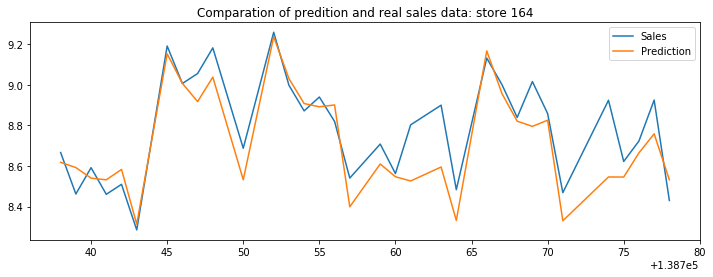

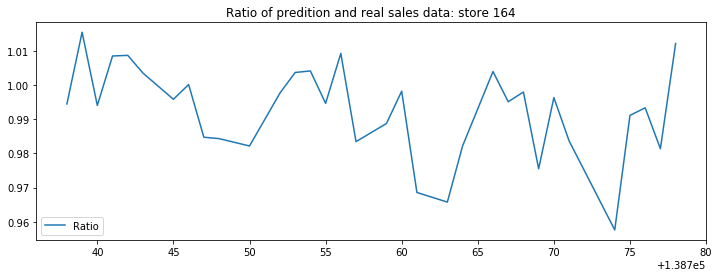

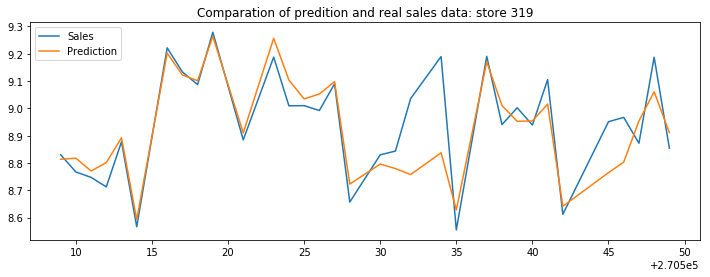

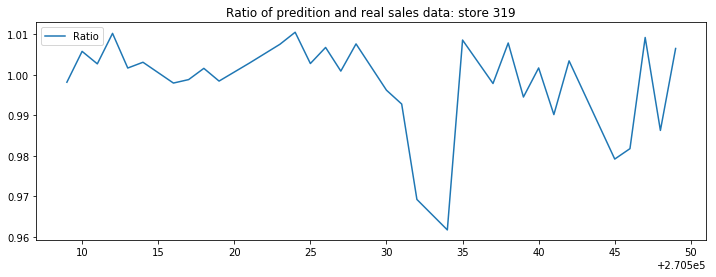

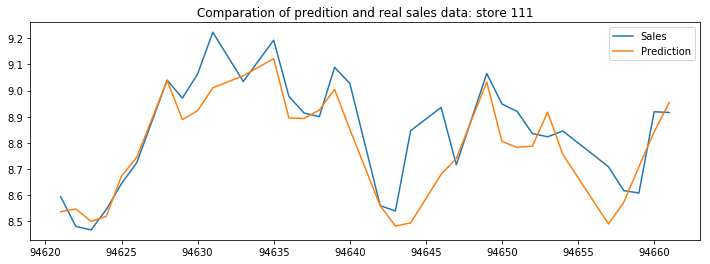

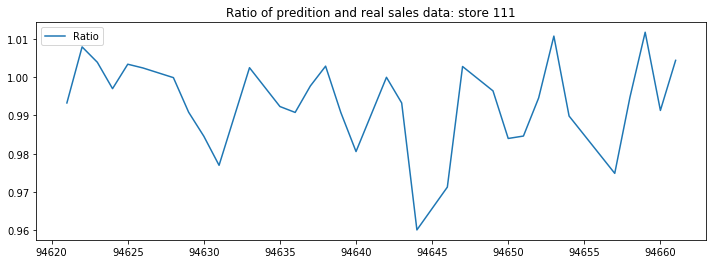

In [26]:
col_1 = ['Sales','Prediction']
col_2 = ['Ratio']
L=np.random.randint( low=1,high = 1115, size = 3 ) 
print('Mean Ratio of predition and real sales data is {}: store all'.format(res.Ratio.mean()))
for i in L:
    
    s1 = pd.DataFrame(res[res['Store']==i],columns = col_1)
    s2 = pd.DataFrame(res[res['Store']==i],columns = col_2)
    s1.plot(title = 'Comparation of predition and real sales data: store {}'.format(i),figsize=(12,4))
    s2.plot(title = 'Ratio of predition and real sales data: store {}'.format(i),figsize=(12,4))
    print('Mean Ratio of predition and real sales data is {}: store {}'.format(s2.Ratio.mean(),i))


In [27]:
# the worst 10 samples
res.sort_values(['Error'],ascending=False,inplace= True)
res[:10]

,Store,DayOfWeek,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,...,Day,WeekOfYear,CompetitionOpen,PromoOpen,IsPromoMonth,Sales,Prediction,Ratio,Error,Weight
154568,183,4,1,1,0,1,1,9670.0,0.0,0.0,...,1,18,24185.0,24184.50,0,7.167038,8.366320,1.167333,0.167333,0.856654
826339,971,2,0,0,0,3,1,1140.0,5.0,2011.0,...,22,17,47.0,36.75,0,9.854245,8.692194,0.882076,0.117924,1.133689
826338,971,1,0,0,0,3,1,1140.0,5.0,2011.0,...,21,17,47.0,36.75,0,9.876271,8.767840,0.887768,0.112232,1.126420
826349,971,5,0,0,0,3,1,1140.0,5.0,2011.0,...,2,18,48.0,37.00,0,8.206584,9.079910,1.106418,0.106418,0.903818
242396,286,5,0,0,0,1,1,1460.0,4.0,2015.0,...,30,22,1.0,24185.50,0,7.367709,8.136343,1.104325,0.104325,0.905531
826337,971,0,0,0,0,3,1,1140.0,5.0,2011.0,...,20,17,47.0,36.75,0,9.737787,8.766395,0.900245,0.099755,1.110809
826346,971,2,1,0,0,3,1,1140.0,5.0,2011.0,...,29,18,47.0,37.00,0,8.325306,9.144480,1.098396,0.098396,0.910419
242382,286,5,0,0,0,1,1,1460.0,4.0,2015.0,...,16,20,1.0,24185.00,0,7.229839,7.938694,1.098046,0.098046,0.910709
154597,183,5,0,0,0,1,1,9670.0,0.0,0.0,...,30,22,24185.0,24185.50,0,9.040501,8.154507,0.901997,0.098003,1.108651
826340,971,3,0,0,0,3,1,1140.0,5.0,2011.0,...,23,17,47.0,36.75,0,9.573594,8.709609,0.909753,0.090247,1.099199


weight correction
RMSPE for 0.990:0.150789
RMSPE for 0.991:0.145958
RMSPE for 0.992:0.141367
RMSPE for 0.993:0.137053
RMSPE for 0.994:0.133054
RMSPE for 0.995:0.129415
RMSPE for 0.996:0.126179
RMSPE for 0.997:0.123392
RMSPE for 0.998:0.121102
RMSPE for 0.999:0.119351
RMSPE for 1.000:0.118180
RMSPE for 1.001:0.117623
RMSPE for 1.002:0.117704
RMSPE for 1.003:0.118441
RMSPE for 1.004:0.119837
RMSPE for 1.005:0.121889
RMSPE for 1.006:0.124579
RMSPE for 1.007:0.127885
RMSPE for 1.008:0.131779
RMSPE for 1.009:0.136225
Best weight for Score:1.001    0.117623
dtype: float64


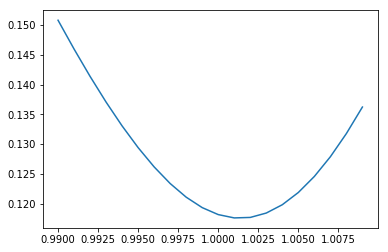

In [28]:
# whole correction
print("weight correction")
W=[(0.990+(i/1000)) for i in range(20)]
S =[]
for w in W:
    error = rmspe(np.expm1(ho_ytest), np.expm1(yhat*w))
    print('RMSPE for {:.3f}:{:.6f}'.format(w,error))
    S.append(error)
Score = pd.Series(S,index=W)
Score.plot()
BS = Score[Score.values == Score.values.min()]
print ('Best weight for Score:{}'.format(BS))

In [29]:
# correction by store
L=range(1115)
W_ho=[]
W_test=[]
for i in L:
    s1 = pd.DataFrame(res[res['Store']==i+1],columns = col_1)
    s2 = pd.DataFrame(xtest[xtest['Store']==i+1])
    W1=[(0.990+(i/1000)) for i in range(20)]
    S =[]
    for w in W1:
        error = rmspe(np.expm1(s1.Sales), np.expm1(s1.Prediction*w))
        S.append(error)
    Score = pd.Series(S,index=W1)
    BS = Score[Score.values == Score.values.min()]
    a=np.array(BS.index.values)
    b_ho=a.repeat(len(s1))
    b_test=a.repeat(len(s2))
    W_ho.extend(b_ho.tolist())
    W_test.extend(b_test.tolist())

In [30]:
yhat_new = yhat*W_ho
error = rmspe(np.expm1(ho_ytest), np.expm1(yhat_new))
print ('RMSPE for weight corretion {:6f}'.format(error))

RMSPE for weight corretion 0.114023


In [31]:
print("Make predictions on the test set")
dtest = xgb.DMatrix(xtest)
test_probs = gbm.predict(dtest)

# model1  kaggle private score 0.12647
result = pd.DataFrame({"ID": test['ID'], 'Sales': np.expm1(test_probs)})
result.to_csv("Rossmann_submission_1.csv", index=False)

# model2 kaggle private score 0.11756
result = pd.DataFrame({"ID": test['ID'], 'Sales': np.expm1(test_probs*1.0001)})
result.to_csv("Rossmann_submission_2.csv", index=False)

# model3 kaggle private score 0.11292
result = pd.DataFrame({"ID": test['ID'], 'Sales': np.expm1(test_probs*W_test)})
result.to_csv("Rossmann_submission_3.csv", index=False)


Make predictions on the test set


In [ ]:
# ensemble XGBoost model with best kaggle private score 0.11048(20th), but cost too much time (about 7h)
'''
print("Train an new ensemble XGBoost model")
start = time()
rounds = 10
preds_ho = np.zeros((len(ho_xtest.index), rounds))
preds_test = np.zeros((len(test.index), rounds))
B=[]
for r in range(rounds):
    print('round {}:'.format(r+1))
    
    params = {"objective": "reg:linear",
          "booster" : "gbtree",
          "eta": 0.03,
          "max_depth": 10,
          "subsample": 0.9,
          "colsample_bytree": 0.7,
          "silent": 1,
          "seed": r+1
          }
    num_boost_round = 6000
    gbm = xgb.train(params, dtrain, num_boost_round, evals=watchlist, 
                    early_stopping_rounds=100, feval=rmspe_xg, verbose_eval=True)
    
    yhat = gbm.predict(xgb.DMatrix(ho_xtest))
    
    L=range(1115)
    W_ho=[]
    W_test=[]
    for i in L:
        s1 = pd.DataFrame(res[res['Store']==i+1],columns = col_1)
        s2 = pd.DataFrame(xtest[xtest['Store']==i+1])
        W1=[(0.990+(i/1000)) for i in range(20)]
        S =[]
        for w in W1:
            error = rmspe(np.expm1(s1.Sales), np.expm1(s1.Prediction*w))
            S.append(error)
        Score = pd.Series(S,index=W1)
        BS = Score[Score.values == Score.values.min()]
        a=np.array(BS.index.values)
        b_ho=a.repeat(len(s1))
        b_test=a.repeat(len(s2))
        W_ho.extend(b_ho.tolist())
        W_test.extend(b_test.tolist())
    

    yhat_ho = yhat*W_ho
    yhat_test =gbm.predict(xgb.DMatrix(xtest))*W_test
    error = rmspe(np.expm1(ho_ytest), np.expm1(yhat_ho))
    B.append(error)
    preds_ho[:, r] = yhat_ho
    preds_test[:, r] = yhat_test
    print('round {} end'.format(r+1))
    
end = time()
time_elapsed = end-start
print('Training is end')
print('Training time is {} h.'.format(time_elapsed/3600))   
'''

In [ ]:
'''
print ('Validating')

bagged_ho_preds1 = preds_ho.mean(axis = 1)
error1 = rmspe(np.expm1(ho_ytest), np.expm1(bagged_ho_preds1))
print('RMSPE for mean: {:.6f}'.format(error1))


R = range(10)   
Mw = [0.20,0.20,0.10,0.10,0.10,0.10,0.10,0.10,0.00,0.00] 
A = pd.DataFrame()
A['round']=R
A['best_score']=B
A.sort_values(['best_score'],inplace = True)
A['weight']=Mw
A.sort_values(['round'],inplace = True)
weight=np.array(A['weight'])
preds_ho_w=weight*preds_ho
bagged_ho_preds2 = preds_ho_w.sum(axis = 1)
error2 = rmspe(np.expm1(ho_ytest), np.expm1(bagged_ho_preds2))
print('RMSPE for weight: {:.6f}'.format(error2))
'''

In [ ]:
'''
print("Make predictions on the test set")
#model4
bagged_preds = preds_test.mean(axis = 1)
result = pd.DataFrame({"Id": test['Id'], 'Sales': np.expm1(bagged_preds)})
result.to_csv("Rossmann_submission_4.csv", index=False)
# modle5
bagged_preds = (preds_test*weight).sum(axis = 1)
result = pd.DataFrame({"Id": test['Id'], 'Sales': np.expm1(bagged_preds)})
result.to_csv("Rossmann_submission_5.csv", index=False)
'''

In [ ]:
# feature importance
xgb.plot_importance(gbm)